In [1]:
import os, gc
import numpy as np
import pandas as pd 
from pathlib import Path
import matplotlib.pyplot as plt
from typing import List, Dict
from tqdm.notebook import tqdm

from sklearn.model_selection import KFold, GroupKFold

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2
from torch.optim.lr_scheduler import OneCycleLR
from time import time, ctime

from engine_hms_trainer import (
    seed_everything, calc_entropy, evaluate_oof, get_logger, TARGETS, TARGETS_PRED, Trainer
)
from engine_hms_model import (
    KagglePaths, LocalPaths, ModelConfig
)

from scipy.signal import butter, lfilter, freqz
from scipy.stats import entropy
from scipy.special import rel_entr


In [2]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PATHS = KagglePaths if os.path.exists(KagglePaths.OUTPUT_DIR) else LocalPaths
print("Output Dir: ", PATHS.OUTPUT_DIR)

EEG_FEAT_ALL = [
    'Fp1', 'F3', 'C3', 'P3', 
    'F7', 'T3', 'T5', 'O1', 
    'Fz', 'Cz', 'Pz', 'Fp2', 
    'F4', 'C4', 'P4', 'F8', 
    'T4', 'T6', 'O2', 'EKG'
    ]

EEG_FEAT_USE =  ['Fp1','T3','C3','O1','Fp2','C4','T4','O2']
EEF_FEAT_INDEX = {x:y for x,y in zip(EEG_FEAT_USE, range(len(EEG_FEAT_USE)))}

seed_everything(ModelConfig.SEED)

Output Dir:  ./outputs/


# Load Data

In [10]:
def eeg_from_parquet(parquet_path: str, use_feature=EEG_FEAT_USE, display: bool = False) -> np.ndarray:
    # === Extract full length EEG Sequence ===
    # fill missing values with mean
    # first fill missing values with mean of each column
    # then if all values are missing, fill with 0
    eeg = pd.read_parquet(parquet_path, columns=use_feature)
    eeg = eeg.fillna(eeg.mean(skipna=True)).fillna(0)
    data = eeg.values.astype(np.float32)

    if display:
        fig, ax = plt.subplots(len(use_feature), 1, figsize=(15, 3*len(use_feature)), sharex=True)
        
        for i, feat in enumerate(use_feature):
            ax[i].plot(data[:, i], label=feat)
            ax[i].legend()
            ax[i].grid()
       
        name = parquet_path.split('/')[-1].split('.')[0]
        ax[0].set_title(f'EEG {name}',size=16)
        fig.tight_layout()
        plt.show()    
    return data

def get_non_overlap(train_csv, targets):

    df = train_csv.groupby(['eeg_id'] + targets).agg({
            'spectrogram_id': 'first',
            'spectrogram_label_offset_seconds': ['min', 'max'],
            'eeg_label_offset_seconds': ['min', 'max'],
            'patient_id': 'first',
            'expert_consensus': 'first',
            'total_votes': 'sum',
            'entropy': 'mean',
            'is_hard': 'mean'
        }).reset_index()

    df.columns = ["eeg_id"] + targets + \
        ['spectrogram_id', 'min', 'max', 'eeg_off_min', 'eeg_off_max', 'patient_id', 'target', 'total_votes', 'average_entropy', 'is_hard']

    df[targets] = df[targets].apply(lambda x: x / x.sum(), axis=1)

    return df

In [11]:
CREATE_EEGS = False
ALL_EEG_SIGNALS = {}
eeg_paths = list(Path(PATHS.TRAIN_EEGS).glob('*.parquet'))
preload_eegs_path = Path('./inputs/eegs_full.npy')

if CREATE_EEGS:
    count = 0
    for parquet_path in tqdm(eeg_paths, total=len(eeg_paths)):
        eeg_id = int(parquet_path.stem)
        eeg_path = str(parquet_path)
        data = eeg_from_parquet(eeg_path, display=count<1)
        ALL_EEG_SIGNALS[eeg_id] = data
        count += 1
    np.save("./inputs/eegs_full.npy", ALL_EEG_SIGNALS)
else:
    ALL_EEG_SIGNALS = np.load(preload_eegs_path, allow_pickle=True).item()

In [12]:
train_csv = pd.read_csv(PATHS.TRAIN_CSV)
targets = train_csv.columns[-6:].tolist()

print("targets: ", targets)

train_csv['total_votes'] = train_csv[targets].sum(axis=1)

targets_prob = [f"{t.split('_')[0]}_prob" for t in targets]
train_csv[targets_prob] = train_csv[targets].div(train_csv['total_votes'], axis=0)

train_csv['entropy'] = train_csv[targets_prob].apply(lambda row: sum(rel_entr([1/6]*6, row.values+1e-5)), axis=1)
train_csv['is_hard'] = (train_csv['entropy'] < 5.5).astype(int)

train_all = get_non_overlap(train_csv, targets)
train_hard = get_non_overlap(train_csv[train_csv['is_hard'] == 1].copy().reset_index(), targets)

print("train_all: ", train_all.shape)
print("hard samples: ", train_hard.shape)

train_all.head(15)

targets:  ['seizure_vote', 'lpd_vote', 'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote']
train_all:  (20183, 17)
hard samples:  (4096, 17)


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,eeg_off_min,eeg_off_max,patient_id,target,total_votes,average_entropy,is_hard
0,568657,0.000000,0.000000,0.250000,0.000000,0.166667,0.583333,789577333,0.0,16.0,0.0,16.0,20654,Other,48,4.584192,1.0
1,582999,0.000000,0.857143,0.000000,0.071429,0.000000,0.071429,1552638400,0.0,38.0,0.0,38.0,20230,LPD,154,4.870032,1.0
2,642382,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,14960202,1008.0,1032.0,0.0,24.0,5955,Other,2,7.802343,0.0
3,751790,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,618728447,908.0,908.0,0.0,0.0,38549,GPD,1,7.802343,0.0
4,778705,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,52296320,0.0,0.0,0.0,0.0,40955,Other,2,7.802343,0.0
5,1629671,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2036345030,0.0,160.0,0.0,160.0,37481,Seizure,51,7.802343,0.0
6,1895581,0.076923,0.000000,0.000000,0.000000,0.076923,0.846154,128369999,1138.0,1138.0,0.0,0.0,47999,Other,13,4.847483,1.0
7,2061593,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,320962633,1450.0,1450.0,0.0,0.0,23828,Other,1,7.802343,0.0
8,2078097,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2074135650,3342.0,3342.0,0.0,0.0,61174,Other,2,7.802343,0.0
9,2366870,0.000000,0.333333,0.000000,0.000000,0.000000,0.666667,1232582129,0.0,30.0,0.0,30.0,23633,Other,18,6.134196,0.0


In [13]:
ModelConfig.MODEL_BACKBONE = 'reset_gru'
ModelConfig.MODEL_NAME = "EEGSeq_Wavenet"
ModelConfig.BATCH_SIZE = 16
ModelConfig.GRADIENT_ACCUMULATION_STEPS = 1
ModelConfig.EPOCHS = 30
ModelConfig.DROP_RATE = 0.1
ModelConfig.EARLY_STOP_ROUNDS = 5

ModelConfig.RESNET_GRU_HIDDEN_SIZE = 424 # 448
ModelConfig.RESNET_GRU_INPUT_SIZE = 8
ModelConfig.RESNET_GRU_N_BLOCKS = 9
ModelConfig.RESNET_GRU_KERNELS = [3, 5, 7, 9] # [3, 5, 7, 9, 11]
ModelConfig.RESNET_GRU_FIXED_KERNEL_SIZE = 5
ModelConfig.RESNET_GRU_DROPOUT = 0.0
ModelConfig.RESNET_GRU_DOWNSAMPLE = None # None

logger = get_logger(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_train.log")

# Dataset

In [14]:
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter(order, [lowcut, highcut], fs=fs, btype='band')
    y = lfilter(b, a, data)
    return y

def denoise_filter(x):
    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 200.0
    lowcut = 1.0
    highcut = 25.0
    
    # Filter a noisy signal.
    T = 50
    nsamples = T * fs
    t = np.arange(0, nsamples) / fs
    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=6)
    y = (y + np.roll(y,-1)+ np.roll(y,-2)+ np.roll(y,-3))/4
    y = y[0:-1:4]
    
    return y

def mu_law_encoding(data, mu):
    mu_x = np.sign(data) * np.log(1 + mu * np.abs(data)) / np.log(mu + 1)
    return mu_x

def mu_law_expansion(data, mu):
    s = np.sign(data) * (np.exp(np.abs(data) * np.log(mu + 1)) - 1) / mu
    return s

def quantize_data(data, classes):
    mu_x = mu_law_encoding(data, classes)
    return mu_x #quantized

def butter_lowpass_filter(data, cutoff_freq=20, sampling_rate=200, order=4):
    nyquist = 0.5 * sampling_rate
    normal_cutoff = cutoff_freq / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_data = lfilter(b, a, data, axis=0)
    return filtered_data


In [15]:
class EEGSeqDataset(Dataset):
    def __init__(self, df, config, eegs, mode='train', verbose=False):
        self.df = df
        self.mode = mode
        self.eegs = eegs
        self.verbose = verbose
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        
        X, y_prob = self.__data_generation(idx)
        
        return torch.tensor(X, dtype=torch.float32), torch.tensor(y_prob, dtype=torch.float32)
    
    def __data_generation(self, index):
        row = self.df.iloc[index]

        if self.verbose:
            print(f"Row {index}", row[['eeg_id', 'eeg_off_min', 'eeg_off_max', 'target']].tolist())

        X = np.zeros((10_000, 8), dtype='float32')
        
        if self.mode == 'train':
            start_sec = int((row['eeg_off_min'] + row['eeg_off_max']) // 2)
            data = self.eegs[row.eeg_id][start_sec*200 : (start_sec+50)*200]
        else:
            data = self.eegs[row.eeg_id]

        # === Feature engineering ===
        X[:,0] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['T3']]
        X[:,1] = data[:,EEF_FEAT_INDEX['T3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,2] = data[:,EEF_FEAT_INDEX['Fp1']] - data[:,EEF_FEAT_INDEX['C3']]
        X[:,3] = data[:,EEF_FEAT_INDEX['C3']] - data[:,EEF_FEAT_INDEX['O1']]

        X[:,4] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['C4']]
        X[:,5] = data[:,EEF_FEAT_INDEX['C4']] - data[:,EEF_FEAT_INDEX['O2']]

        X[:,6] = data[:,EEF_FEAT_INDEX['Fp2']] - data[:,EEF_FEAT_INDEX['T4']]
        X[:,7] = data[:,EEF_FEAT_INDEX['T4']] - data[:,EEF_FEAT_INDEX['O2']]

        # === Standarize ===
        X = np.clip(X,-1024, 1024)
        X = np.nan_to_num(X, nan=0) / 32.0

        # === Butter Low-pass Filter ===
        # !!! change to bandpass filter (low=0.5, hight=20, order=2) !!!
        # X = butter_lowpass_filter(X)
        X = butter_bandpass_filter(X, .5, 20, 200, order=2)

        if self.mode != 'test':
            y_prob = row[TARGETS].values.astype(np.float32)
        else:
            y_prob = np.zeros(6, dtype='float32')

        return X, y_prob


In [16]:
# visualize the dataset

# train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
# train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

# for batch in train_loader:
#     X, y = batch
#     print(f"X shape: {X.shape}")
#     print(f"y shape: {y.shape}")
    
    # fig, axes = plt.subplots(4, 1, figsize=(20, 20))
    # for item in range(4):
    #     offset = 0
    #     for col in range(X.shape[-1]):
    #         if col != 0:
    #             offset -= X[item,:,col].min()
    #         axes[item].plot(np.arange(X.shape[1]), X[item,:,col]+offset, label=f'feature {col+1}')
    #         offset += X[item,:,col].max()
    #     tt = f'{y[col][0]:0.1f}'
    #     for t in y[col][1:]:
    #         tt += f', {t:0.1f}'
    #     axes[item].set_title(f'Target = {tt}',size=14)
    #     axes[item].legend()
    # fig.tight_layout()
    # plt.show()
    # break

# Model

In [17]:
class SeqGRUEncoder(nn.Module):
    def __init__(self, in_channels, hidden_size=128, num_layers=2, bidirectional=True):
        super(SeqGRUEncoder, self).__init__()

        self.in_channels = in_channels

        # Initialize the GRU to have 128 hidden units per direction and to be bidirectional
        self.rnn = nn.GRU(
            input_size=in_channels, 
            hidden_size=hidden_size, 
            num_layers=num_layers,
            bidirectional=bidirectional, 
            batch_first=True
        )
        
        # Initialize the attention mechanism
        if bidirectional:
            emb_dim = 2 * hidden_size
        else:
            emb_dim = hidden_size
        
        self.attention_dense = nn.Linear(emb_dim, 1)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        rnn_out, _ = self.rnn(x)  # -> [batch, seq_len, emb_dim]
        identity = rnn_out
        scores = self.attention_dense(rnn_out).squeeze(-1)
        scores = self.softmax(scores).unsqueeze(1)
        pooled_out = torch.matmul(scores, identity).squeeze(1)
        # -> [batch_size, emb_dim]
        return pooled_out

In [18]:
class ResNet_1D_Block(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling, dropout=0.0):
        super(ResNet_1D_Block, self).__init__()
        self.block = nn.Sequential(
            nn.BatchNorm1d(num_features=in_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm1d(num_features=out_channels),
            nn.ReLU(),
            nn.Dropout(p=dropout),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        )
        self.downsampling = downsampling

    def forward(self, x):
        identity = self.downsampling(x)
        out = self.block(x)
        out += identity
        return out
    
class ResNet_1D_Encoder(nn.Module):
    def __init__(self, kernels=[3,7,9,11], planes=24, in_channels=8, fixed_kernel_size=5, n_blocks=9, dropout=0.0):
        super(ResNet_1D_Encoder, self).__init__()

        self.parallel_conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=in_channels, 
                out_channels=planes, 
                kernel_size=kernel_size,
                stride=1, 
                padding=0, 
                bias=False
            ) for kernel_size in kernels
        ])

        self.resnet_layer = ResNet_1D_Block(
            in_channels=planes, 
            out_channels=planes, 
            kernel_size=fixed_kernel_size,
            stride=1, 
            padding=fixed_kernel_size//2, 
            downsampling=nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
            dropout=dropout
        )
        
        self.resnet_part = nn.Sequential(
            nn.BatchNorm1d(num_features=planes),
            nn.ReLU(inplace=False),
            nn.Conv1d(
                in_channels=planes, 
                out_channels=planes, 
                kernel_size=fixed_kernel_size, 
                stride=2, 
                padding=2, 
                bias=False
            ),
            *[self.resnet_layer for _ in range(n_blocks)],
            nn.BatchNorm1d(num_features=planes),
            nn.ReLU(),
            nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
        )

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        print("Resnet Input Shape: ", x.shape)
        x = x.permute(0, 2, 1)  # (batch, channels, seq_len)
       
        out_sep = [conv(x) for conv in self.parallel_conv]
        out = torch.cat(out_sep, dim=2)
        out = self.resnet_part(out)
        
        # Return the flattened features from the last convolutional layer
        features = out.reshape(out.shape[0], -1)
        return features


In [19]:
from typing import List

class DilatedInception(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_sizes: List[int], dilation: int) -> None:
        super().__init__()
        assert out_channels % len(kernel_sizes) == 0, "`out_channels` must be divisible by the number of kernel sizes."
        hidden_dim = out_channels // len(kernel_sizes)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels, hidden_dim, k, padding='same', dilation=dilation)
            for k in kernel_sizes
        ])

    def forward(self, x):
        outputs = [conv(x) for conv in self.convs]
        out = torch.cat(outputs, dim=1)
        return out

class GatedTCN(nn.Module):
    def __init__(self, in_dim: int, h_dim: int, kernel_sizes: List[int], dilation_factor: int, dropout: float = 0.0) -> None:
        super().__init__()
        self.filt = DilatedInception(in_dim, h_dim, kernel_sizes, dilation=dilation_factor)
        self.gate = DilatedInception(in_dim, h_dim, kernel_sizes, dilation=dilation_factor)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x_filt = torch.tanh(self.filt(x))
        x_gate = torch.sigmoid(self.gate(x))
        h = x_filt * x_gate
        h = self.dropout(h)
        return h

class WaveBlock(nn.Module):
    def __init__(self, n_layers: int, in_dim: int, h_dim: int, kernel_sizes: List[int]) -> None:
        super().__init__()
        self.dilation_rates = [2**i for i in range(n_layers)]
        self.in_conv = nn.Conv1d(in_dim, h_dim, kernel_size=1)
        self.gated_tcns = nn.ModuleList([
            GatedTCN(h_dim, h_dim, kernel_sizes, dilation)
            for dilation in self.dilation_rates
        ])
        self.skip_convs = nn.ModuleList([
            nn.Conv1d(h_dim, h_dim, kernel_size=1)
            for _ in range(n_layers)
            ])
        self._initialize_weights()

    def _initialize_weights(self):
        nn.init.xavier_uniform_(self.in_conv.weight, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(self.in_conv.bias)
        for conv in self.skip_convs:
            nn.init.xavier_uniform_(conv.weight, gain=nn.init.calculate_gain('relu'))
            nn.init.zeros_(conv.bias)

    def forward(self, x):
        # x: (B, C, L)
        x = self.in_conv(x)
        x_skip = x
        for gated_tcn, skip_conv in zip(self.gated_tcns, self.skip_convs):
            x = gated_tcn(x)
            x = skip_conv(x)
            x_skip = x_skip + x
        return x_skip

class DilatedWaveNet(nn.Module):
    """WaveNet architecture with dilated inception conv, enhanced with list comprehension for input processing."""

    def __init__(self, kernel_sizes: List[int]) -> None:
        super().__init__()
        self.kernel_sizes = kernel_sizes
        
        # Initialize wave blocks with specified kernel sizes
        self.wave_module = nn.Sequential(
            WaveBlock(12, 1, 16, self.kernel_sizes),
            WaveBlock(8, 16, 32, self.kernel_sizes),
            WaveBlock(4, 32, 64, self.kernel_sizes),
            WaveBlock(1, 64, 64, self.kernel_sizes),
        )
        self.pool_layer = nn.AdaptiveAvgPool1d(1)

    def forward(self, x) -> torch.Tensor:
        # x: (B, L, C)
        bs, seq_len, n_channels = x.shape
        x = x.permute(0, 2, 1) # -> (B, C, L)
        # Process different parts of the input with list comprehension
        pooled_outputs = [
            (
                self.pool_layer(self.wave_module(x[:, i:i+1])) + 
                self.pool_layer(self.wave_module(x[:, i+1:i+2]))
            ) / 2
            for i in range(0, n_channels, 2)
        ]

        # Combine the pooled features and reshape for classification
        features = torch.cat(pooled_outputs, dim=1).reshape(bs, -1)
       
        return features

In [20]:
class EEGSeqClassifier(nn.Module):
    def __init__(self, config, num_classes=6):
        super(EEGSeqClassifier, self).__init__()

        # downsample layer (by a factor of 2)
        self.ds_layer = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=3, stride=2, padding=1)
        
        # self.seqgru = SeqGRUEncoder(in_channels=8, hidden_size=128, num_layers=2, bidirectional=True)
        # self.resnet = ResNet_1D_Encoder(
        #     kernels=[3, 7, 9, 11], 
        #     planes=24, 
        #     in_channels=8, 
        #     fixed_kernel_size=5, 
        #     n_blocks=8, 
        #     dropout=0.0
        # )
        self.wavenet = DilatedWaveNet(kernel_sizes=[2, 3, 6, 7])

        self.predict_head = nn.Linear(64*4, num_classes)

    def forward(self, x):
        # x shape: [batch, seq_len, in_channels]
        x = self.ds_layer(x.permute(0, 2, 1)) # ->(batch, channels, seq_len)
        x = x.permute(0, 2, 1)
        # resnet_out = self.resnet(x)
        # seqgru_out = self.seqgru(x)
        wavenet_out = self.wavenet(x)
        
        # features = torch.cat([seqgru_out, resnet_out, wavenet_out], dim=1)

        logits = self.predict_head(wavenet_out)
        return logits

In [21]:
# class ResNet_1D_Block(nn.Module):
#     def __init__(self, in_channels, out_channels, kernel_size, stride, padding, downsampling, dropout=0.0):
#         super(ResNet_1D_Block, self).__init__()
#         self.block = nn.Sequential(
#             nn.BatchNorm1d(num_features=in_channels),
#             nn.ReLU(),
#             nn.Dropout(p=dropout),
#             nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
#             nn.BatchNorm1d(num_features=out_channels),
#             nn.ReLU(),
#             nn.Dropout(p=dropout),
#             nn.Conv1d(out_channels, out_channels, kernel_size, stride, padding, bias=False),
#             nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         )
#         self.downsampling = downsampling

#     def forward(self, x):
#         identity = self.downsampling(x)
#         out = self.block(x)
#         out += identity
#         return out

# class SeqPool(nn.Module):
#     def __init__(self, emb_dim):
#         super().__init__()
#         self.dense = nn.Linear(emb_dim, 1)  # Dense layer to compute attention scores
#         self.softmax = nn.Softmax(dim=-1)   # Softmax to normalize scores

#     def forward(self, x):
#         # x shape: [batch_size, seq_len, emb_dim]
#         bs, seq_len, emb_dim = x.shape
#         identity = x
#         scores = self.dense(x)
#         scores = scores.squeeze(-1).softmax(dim=-1)
#         scores = scores.unsqueeze(1)
#         pooled_output = torch.matmul(scores, identity)
#         # Final shape: [batch_size, emb_dim]
#         pooled_output = pooled_output.squeeze(1)
#         return pooled_output


# class SeqGRU(nn.Module):
#     def __init__(self, in_channels, ):
#         super(SeqGRU, self).__init__()

#         self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=2, bidirectional=True)
#         self.seq_pool = SeqPool(emb_dim=256)

#     def forward(self, x):

#         # x_down = self.downsample_block(x.permute(0, 2, 1))
#         rnn_out, _ = self.rnn(x)
#         new_rnn_h = self.seq_pool(rnn_out)
#         return new_rnn_h


In [22]:
# # Define ResNetGRU model
# class ResNet_1D(nn.Module):

#     def __init__(self, config, num_classes=6):
#         super(ResNet_1D, self).__init__()

#         self.kernels = config.RESNET_GRU_KERNELS
#         self.planes = 24
#         self.in_channels = config.RESNET_GRU_INPUT_SIZE

#         # Define the separate convolutional layers
#         self.parallel_conv = nn.ModuleList([
#             nn.Conv1d(
#                 in_channels=self.in_channels, 
#                 out_channels=self.planes, 
#                 kernel_size=kernel_size,
#                 stride=1, 
#                 padding=0, 
#                 bias=False
#             ) for kernel_size in self.kernels
#         ])

#         fixed_kernel_size = config.RESNET_GRU_FIXED_KERNEL_SIZE

#         self.resnet_layer = ResNet_1D_Block(
#             in_channels=self.planes, 
#             out_channels=self.planes, 
#             kernel_size=fixed_kernel_size,
#             stride=1, 
#             padding=fixed_kernel_size//2, 
#             downsampling= nn.MaxPool1d(kernel_size=2, stride=2, padding=0),
#             dropout=config.RESNET_GRU_DROPOUT
#             )
        
#         # Define the ResNet part of the model
#         self.resnet_part = nn.Sequential(
#             nn.BatchNorm1d(num_features=self.planes),
#             nn.ReLU(inplace=False),
#             nn.Conv1d(
#                 in_channels=self.planes, 
#                 out_channels=self.planes, 
#                 kernel_size=fixed_kernel_size, 
#                 stride=2, 
#                 padding=2, 
#                 bias=False
#             ),
#             *[self.resnet_layer for _ in range(config.RESNET_GRU_N_BLOCKS)],
#             nn.BatchNorm1d(num_features=self.planes),
#             nn.ReLU(inplace=False),
#             nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
#         )

#         # Define the final fully connected layer
#         self.fc = nn.Linear(in_features=168, out_features=num_classes)

#     def forward(self, x):
#         x = x.permute(0, 2, 1) # (batch, channels, seq_len)
       
#         out_sep = [conv(x) for conv in self.parallel_conv]
#         out = torch.cat(out_sep, dim=2)
#         out = self.resnet_part(out)
#         out = out.reshape(out.shape[0], -1)

#         result = self.fc(out)
#         return result


# class ResNetGRU(nn.Module):
#     def __init__(self, config, num_classes=6):
#         super(ResNetGRU, self).__init__()

#         self.kernels = config.RESNET_GRU_KERNELS
#         self.planes = 24
#         self.in_channels = config.RESNET_GRU_INPUT_SIZE

#         # self.downsample_block = nn.Sequential(
#         #     nn.Conv1d(
#         #         in_channels=self.in_channels, 
#         #         out_channels=self.in_channels, 
#         #         kernel_size=5, 
#         #         stride=5,
#         #         dilation=2, 
#         #         padding=2, 
#         #     ),
#         #     nn.ReLU(),
#         #     nn.BatchNorm1d(num_features=self.in_channels)
#         # )

#         # # Define the separate convolutional layers
#         self.parallel_conv = self._make_parallel_conv_layers()

#         # Define the ResNet part of the model
#         self.resnet_part = self._make_resnet_part(
#             config.RESNET_GRU_FIXED_KERNEL_SIZE, config.RESNET_GRU_N_BLOCKS, config.RESNET_GRU_DROPOUT)
        
#         # Define the GRU part of the model
#         self.rnn = nn.GRU(input_size=self.in_channels, hidden_size=128, num_layers=2, bidirectional=True)
#         self.seq_pool = SeqPool(emb_dim=256)

#         # Define the final fully connected layer
#         self.fc = nn.Linear(in_features=424, out_features=num_classes)
#         # self.mlp = nn.Sequential(
#         #     nn.Linear(in_features=config.RESNET_GRU_HIDDEN_SIZE, out_features=256),
#         #     nn.ReLU(inplace=True),
#         #     nn.Dropout(p=config.DROP_RATE),
#         #     nn.Linear(in_features=256, out_features=num_classes)
#         # )

#     def _make_parallel_conv_layers(self):
#         return nn.ModuleList([
#             nn.Conv1d(
#                 in_channels=self.in_channels, 
#                 out_channels=self.planes, 
#                 kernel_size=kernel_size,
#                 stride=1, 
#                 padding=0, 
#                 bias=False
#             ) for kernel_size in self.kernels
#         ])

#     def _make_resnet_part(self, fixed_kernel_size, blocks=9, dropout=0.0):
#         # prepare resnet layers
#         downsampling = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
#         resnet_layers = [
#             ResNet_1D_Block(
#                 in_channels=self.planes, 
#                 out_channels=self.planes, 
#                 kernel_size=fixed_kernel_size, 
#                 stride=1, 
#                 padding=fixed_kernel_size//2, 
#                 downsampling=downsampling,
#                 dropout=dropout)
#             for _ in range(blocks)
#         ]
#         # return the resnet encoder
#         return nn.Sequential(
#             nn.BatchNorm1d(num_features=self.planes),
#             nn.ReLU(inplace=False),
#             nn.Conv1d(
#                 in_channels=self.planes, 
#                 out_channels=self.planes, 
#                 kernel_size=fixed_kernel_size, 
#                 stride=2, 
#                 padding=2, 
#                 bias=False
#             ),
#             *resnet_layers,
#             nn.BatchNorm1d(num_features=self.planes),
#             nn.ReLU(inplace=False),
#             nn.AvgPool1d(kernel_size=6, stride=6, padding=2)
#         )
    
#     def forward(self, x):
        
#         x = x.permute(0, 2, 1) # (batch, channels, seq_len)
#         # x_down = self.downsample_block(x)

#         # extract features using resnet 
#         out_sep = [conv(x) for conv in self.parallel_conv]
#         out = torch.cat(out_sep, dim=2)
#         out = self.resnet_part(out)
#         out = out.reshape(out.shape[0], -1)
        
#         # extract features using rnn
#         rnn_out, _ = self.rnn(x.permute(0, 2, 1))
#         new_rnn_h = x = self.seq_pool(rnn_out)

#         # # concatenate the features
#         new_out = torch.cat([out, new_rnn_h], dim=1) 

#         # pass through the final fully connected layer
#         # result = self.mlp(new_out)
#         result = self.fc(new_out)  
        
#         return result

In [ ]:
train_dataset = EEGSeqDataset(train_all, ModelConfig, ALL_EEG_SIGNALS, mode="train")
train_loader = DataLoader(train_dataset, drop_last=True, batch_size=16, num_workers=4, pin_memory=True, shuffle=False)

# model = SeqGRU( in_channels=8, hidden_size=128, num_layers=2, bidirectional=True)
# model = ResNet_1D_Encoder(in_channels=8)
model = EEGSeqClassifier(ModelConfig, num_classes=6)
model.to(DEVICE)
for i, batch in enumerate(train_loader):
    X, y = batch
    X = X.to(DEVICE)
    y = y.to(DEVICE)
    print(f"X shape: {X.shape}")
    print(f"y shape: {y.shape}")
    
    y_pred = model(X)
    print(y_pred.shape)
    break 

In [23]:
# del model, train_dataset, train_loader
torch.cuda.empty_cache()
gc.collect()

0

In [24]:
!nvidia-smi

Fri Mar 29 20:24:47 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.239.06   Driver Version: 470.239.06   CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:0B:00.0 Off |                  N/A |
| 26%   33C    P8     5W / 260W |   3883MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [25]:
# feature_id = 0
# feat = rnn_out.detach().cpu().numpy()
# print(feat[0].mean(axis=0).shape)

# fig, ax = plt.subplots(2, 1, figsize=(20, 5))
# # for i in range(0, feat.shape[1], 16):
# #     ax[0].plot(feat[:, i].detach().cpu().numpy())
# ax[0].plot(feat[0, -1, :])
# ax[0].plot(feat[0].mean(axis=0))
# ax[1].plot(resnet_out[0].detach().cpu().numpy())

# plt.title(f"Feature {feature_id}")
# plt.show()

# Train

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [27]:
def prepare_k_fold(df, k_folds=5):

    kf = KFold(n_splits=k_folds)
    unique_spec_id = df['spectrogram_id'].unique()
    df['fold'] = k_folds

    for fold, (train_index, valid_index) in enumerate(kf.split(unique_spec_id)):
        df.loc[df['spectrogram_id'].isin(unique_spec_id[valid_index]), 'fold'] = fold

    return df


def train_fold(model, fold_id, train_folds, valid_folds, logger, stage=1, checkpoint=None):

    train_dataset = EEGSeqDataset(train_folds, ModelConfig, ALL_EEG_SIGNALS, mode="train")
    valid_dataset = EEGSeqDataset(valid_folds, ModelConfig, ALL_EEG_SIGNALS, mode="valid")

    # ======== DATALOADERS ==========
    loader_kwargs = {
        "batch_size": ModelConfig.BATCH_SIZE,
        "num_workers": ModelConfig.NUM_WORKERS,
        "pin_memory": True,
        "shuffle": False,
    }

    train_loader = DataLoader(train_dataset, drop_last=True, collate_fn=None, **loader_kwargs)
    valid_loader = DataLoader(valid_dataset, drop_last=False, collate_fn=None, **loader_kwargs)

    trainer = Trainer(model, ModelConfig, logger)
    best_weights, best_preds, loss_records = trainer.train(
        train_loader, valid_loader, from_checkpoint=checkpoint)

    save_model_name = f"{ModelConfig.MODEL_NAME}_fold_{fold_id}_stage_{stage}.pth"
    torch.save(best_weights, os.path.join(PATHS.OUTPUT_DIR, save_model_name))

    del train_dataset, valid_dataset, train_loader, valid_loader
    torch.cuda.empty_cache()
    gc.collect()

    return best_preds, loss_records

In [28]:
k_folds = 5
train_all = prepare_k_fold(train_all, k_folds=k_folds)

# gkf = GroupKFold(n_splits=k_folds)
# for fold, (train_index, valid_index) in enumerate(gkf.split(train_all, train_all.target, train_all.patient_id)):
#     train_all.loc[valid_index, "fold"] = int(fold)

# for fold in range(k_folds):
#     print(f"Fold {fold} = {len(train_all[train_all['fold'] == fold])}")

In [29]:
# Major Train Loop
# ================== Logger ==================
logger.info(f"{'*' * 100}")
logger.info(f"Script Start: {ctime()}")
logger.info(f"Model Configurations:")
for key, value in ModelConfig.__dict__.items():
    if not key.startswith("__"):
        logger.info(f"{key}: {value}")
logger.info(f"{'*' * 100}")

# ================== Run Training ==================
oof_stage_1 = pd.DataFrame()
loss_history_1 = []

logger.info(f"{'=' * 100}\nStage 1: Train ResNetGRU\n{'=' * 100}")
for fold in range(k_folds):
    tik = time()

    ModelConfig.RESNET_GRU_DROPOUT = 0.0

    # model = ResNetGRU( ModelConfig, num_classes=6 )
    model = EEGSeqClassifier(ModelConfig, num_classes=6)
    
    valid_folds = train_all[train_all['fold'] == fold].reset_index(drop=True)
    train_folds = train_all[train_all['fold'] != fold].reset_index(drop=True)

    ## STAGE 1
    logger.info(f"{'=' * 100}\nFold: {fold} || Valid: {valid_folds.shape[0]}; \n{'=' * 100}")
    logger.info(f"- Train: {train_folds.shape[0]}; Epoch = {ModelConfig.EPOCHS}; Dropout = {ModelConfig.RESNET_GRU_DROPOUT} -")
    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=1, checkpoint=None)

    loss_history_1.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_1 = pd.concat([oof_stage_1, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_1.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_1.csv"), index=False)

****************************************************************************************************
Script Start: Fri Mar 29 20:24:53 2024
Model Configurations:
SEED: 20
SPLIT_ENTROPY: 5.5
MODEL_NAME: EEGSeq_Wavenet
MODEL_BACKBONE: reset_gru
BATCH_SIZE: 16
EPOCHS: 30
GRADIENT_ACCUMULATION_STEPS: 1
DROP_RATE: 0.1
DROP_PATH_RATE: 0.25
WEIGHT_DECAY: 0.01
REGULARIZATION: None
USE_KAGGLE_SPECTROGRAMS: True
USE_EEG_SPECTROGRAMS: True
AMP: True
AUGMENT: False
AUGMENTATIONS: ['h_flip', 'v_flip', 'xy_masking', 'cutmix']
PRINT_FREQ: 50
FREEZE: False
NUM_FROZEN_LAYERS: 0
NUM_WORKERS: 0
MAX_GRAD_NORM: 10000000.0
DUAL_ENCODER_BACKBONE: tf_efficientnet_b2
MAE_PRETRAINED_WEIGHTS: facebook/vit-mae-base
MAE_HIDDEN_DROPOUT_PROB: 0.05
MAE_ATTENTION_DROPOUT_PROB: 0.05
EARLY_STOP_ROUNDS: 5
RESNET_GRU_HIDDEN_SIZE: 424
RESNET_GRU_INPUT_SIZE: 8
RESNET_GRU_N_BLOCKS: 9
RESNET_GRU_KERNELS: [3, 5, 7, 9]
RESNET_GRU_FIXED_KERNEL_SIZE: 5
RESNET_GRU_DROPOUT: 0.0
RESNET_GRU_DOWNSAMPLE: None
**************************

Train [0]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 1 [0/804] | Train Loss: 1.7715 Grad: 303500.9688 LR: 4.0000e-06 | Elapse: 1.82s
Epoch 1 [50/804] | Train Loss: 1.5406 Grad: 328130.0312 LR: 4.1059e-06 | Elapse: 35.69s
Epoch 1 [100/804] | Train Loss: 1.5040 Grad: 256567.5469 LR: 4.4151e-06 | Elapse: 69.75s
Epoch 1 [150/804] | Train Loss: 1.4682 Grad: 147090.1719 LR: 4.9261e-06 | Elapse: 104.11s
Epoch 1 [200/804] | Train Loss: 1.4453 Grad: 171396.2812 LR: 5.6369e-06 | Elapse: 138.73s
Epoch 1 [250/804] | Train Loss: 1.4209 Grad: 153045.7188 LR: 6.5444e-06 | Elapse: 173.54s
Epoch 1 [300/804] | Train Loss: 1.4039 Grad: 202389.0938 LR: 7.6448e-06 | Elapse: 208.36s
Epoch 1 [350/804] | Train Loss: 1.3885 Grad: 309029.9062 LR: 8.9334e-06 | Elapse: 243.28s
Epoch 1 [400/804] | Train Loss: 1.3706 Grad: 141204.2500 LR: 1.0405e-05 | Elapse: 278.18s
Epoch 1 [450/804] | Train Loss: 1.3591 Grad: 294451.3750 LR: 1.2053e-05 | Elapse: 312.99s
Epoch 1 [500/804] | Train Loss: 1.3511 Grad: 180521.8281 LR: 1.3870e-05 | Elapse: 347.88s
Epoch 1 [550/804]

Valid [0]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 1 [0/458] | Valid Loss: 1.1598 | Elapse: 0.39s
Epoch 1 [50/458] | Valid Loss: 1.2536 | Elapse: 17.42s
Epoch 1 [100/458] | Valid Loss: 1.2701 | Elapse: 34.33s
Epoch 1 [150/458] | Valid Loss: 1.2602 | Elapse: 51.25s
Epoch 1 [200/458] | Valid Loss: 1.2615 | Elapse: 68.16s
Epoch 1 [250/458] | Valid Loss: 1.2689 | Elapse: 85.05s
Epoch 1 [300/458] | Valid Loss: 1.2746 | Elapse: 101.96s
Epoch 1 [350/458] | Valid Loss: 1.2785 | Elapse: 118.88s
Epoch 1 [400/458] | Valid Loss: 1.2831 | Elapse: 135.78s
Epoch 1 [450/458] | Valid Loss: 1.2853 | Elapse: 152.65s


----------------------------------------------------------------------------------------------------
Epoch 1 - Average Loss: (train) 1.3082; (valid) 1.2839 | Time: 714.23s
Best model found in epoch 1 | valid loss: 1.2839


Epoch 1 [457/458] | Valid Loss: 1.2839 | Elapse: 154.86s


Train [1]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 2 [0/804] | Train Loss: 1.3867 Grad: 161401.7031 LR: 2.8072e-05 | Elapse: 0.70s
Epoch 2 [50/804] | Train Loss: 1.2168 Grad: 136035.8594 LR: 3.0832e-05 | Elapse: 35.46s
Epoch 2 [100/804] | Train Loss: 1.2343 Grad: 171919.2500 LR: 3.3682e-05 | Elapse: 70.56s
Epoch 2 [150/804] | Train Loss: 1.2439 Grad: 275422.5625 LR: 3.6609e-05 | Elapse: 105.57s
Epoch 2 [200/804] | Train Loss: 1.2522 Grad: 156495.4375 LR: 3.9602e-05 | Elapse: 140.53s
Epoch 2 [250/804] | Train Loss: 1.2484 Grad: 115287.6797 LR: 4.2647e-05 | Elapse: 175.54s
Epoch 2 [300/804] | Train Loss: 1.2483 Grad: 231472.0625 LR: 4.5732e-05 | Elapse: 210.65s
Epoch 2 [350/804] | Train Loss: 1.2476 Grad: 327308.7500 LR: 4.8844e-05 | Elapse: 245.66s
Epoch 2 [400/804] | Train Loss: 1.2440 Grad: 122475.8203 LR: 5.1969e-05 | Elapse: 280.66s
Epoch 2 [450/804] | Train Loss: 1.2407 Grad: 271792.8125 LR: 5.5094e-05 | Elapse: 315.80s
Epoch 2 [500/804] | Train Loss: 1.2407 Grad: 165766.0312 LR: 5.8206e-05 | Elapse: 350.80s
Epoch 2 [550/804]

Valid [1]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 2 [0/458] | Valid Loss: 1.0522 | Elapse: 0.34s
Epoch 2 [50/458] | Valid Loss: 1.1795 | Elapse: 17.47s
Epoch 2 [100/458] | Valid Loss: 1.2176 | Elapse: 34.56s
Epoch 2 [150/458] | Valid Loss: 1.1984 | Elapse: 51.60s
Epoch 2 [200/458] | Valid Loss: 1.2015 | Elapse: 68.61s
Epoch 2 [250/458] | Valid Loss: 1.2078 | Elapse: 85.60s
Epoch 2 [300/458] | Valid Loss: 1.2133 | Elapse: 102.55s
Epoch 2 [350/458] | Valid Loss: 1.2171 | Elapse: 119.41s
Epoch 2 [400/458] | Valid Loss: 1.2229 | Elapse: 136.28s
Epoch 2 [450/458] | Valid Loss: 1.2240 | Elapse: 153.09s


----------------------------------------------------------------------------------------------------
Epoch 2 - Average Loss: (train) 1.2219; (valid) 1.2230 | Time: 718.67s
Best model found in epoch 2 | valid loss: 1.2230


Epoch 2 [457/458] | Valid Loss: 1.2230 | Elapse: 155.22s


Train [2]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 3 [0/804] | Train Loss: 1.4614 Grad: 353677.8750 LR: 7.6090e-05 | Elapse: 0.70s
Epoch 3 [50/804] | Train Loss: 1.1528 Grad: 145297.1250 LR: 7.8742e-05 | Elapse: 35.65s
Epoch 3 [100/804] | Train Loss: 1.1581 Grad: 201286.7188 LR: 8.1280e-05 | Elapse: 70.60s
Epoch 3 [150/804] | Train Loss: 1.1629 Grad: 301907.1562 LR: 8.3695e-05 | Elapse: 105.61s
Epoch 3 [200/804] | Train Loss: 1.1714 Grad: 177117.9375 LR: 8.5974e-05 | Elapse: 140.61s
Epoch 3 [250/804] | Train Loss: 1.1611 Grad: 260611.7344 LR: 8.8110e-05 | Elapse: 175.68s
Epoch 3 [300/804] | Train Loss: 1.1531 Grad: 172462.4375 LR: 9.0092e-05 | Elapse: 210.71s
Epoch 3 [350/804] | Train Loss: 1.1508 Grad: 346195.4375 LR: 9.1913e-05 | Elapse: 245.75s
Epoch 3 [400/804] | Train Loss: 1.1480 Grad: 79137.2500 LR: 9.3564e-05 | Elapse: 280.75s
Epoch 3 [450/804] | Train Loss: 1.1408 Grad: 165429.7969 LR: 9.5039e-05 | Elapse: 315.81s
Epoch 3 [500/804] | Train Loss: 1.1370 Grad: 112914.0312 LR: 9.6331e-05 | Elapse: 350.90s
Epoch 3 [550/804] 

Valid [2]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 3 [0/458] | Valid Loss: 0.9605 | Elapse: 0.34s
Epoch 3 [50/458] | Valid Loss: 1.0547 | Elapse: 17.38s
Epoch 3 [100/458] | Valid Loss: 1.0974 | Elapse: 34.36s
Epoch 3 [150/458] | Valid Loss: 1.0728 | Elapse: 51.31s
Epoch 3 [200/458] | Valid Loss: 1.0735 | Elapse: 68.24s
Epoch 3 [250/458] | Valid Loss: 1.0825 | Elapse: 85.07s
Epoch 3 [300/458] | Valid Loss: 1.0933 | Elapse: 101.92s
Epoch 3 [350/458] | Valid Loss: 1.0990 | Elapse: 118.75s
Epoch 3 [400/458] | Valid Loss: 1.1079 | Elapse: 135.59s
Epoch 3 [450/458] | Valid Loss: 1.1101 | Elapse: 152.43s


----------------------------------------------------------------------------------------------------
Epoch 3 - Average Loss: (train) 1.1090; (valid) 1.1087 | Time: 717.67s
Best model found in epoch 3 | valid loss: 1.1087


Epoch 3 [457/458] | Valid Loss: 1.1087 | Elapse: 154.55s


Train [3]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 4 [0/804] | Train Loss: 1.2546 Grad: 317557.9688 LR: 1.0000e-04 | Elapse: 0.70s
Epoch 4 [50/804] | Train Loss: 1.0605 Grad: 137846.7188 LR: 9.9999e-05 | Elapse: 35.66s
Epoch 4 [100/804] | Train Loss: 1.0628 Grad: 227075.2812 LR: 9.9995e-05 | Elapse: 70.73s
Epoch 4 [150/804] | Train Loss: 1.0651 Grad: 386655.9062 LR: 9.9988e-05 | Elapse: 105.79s
Epoch 4 [200/804] | Train Loss: 1.0758 Grad: 192606.3906 LR: 9.9979e-05 | Elapse: 140.86s
Epoch 4 [250/804] | Train Loss: 1.0642 Grad: 293458.1562 LR: 9.9967e-05 | Elapse: 175.89s
Epoch 4 [300/804] | Train Loss: 1.0590 Grad: 194768.1250 LR: 9.9952e-05 | Elapse: 210.98s
Epoch 4 [350/804] | Train Loss: 1.0603 Grad: 307020.3125 LR: 9.9935e-05 | Elapse: 246.09s
Epoch 4 [400/804] | Train Loss: 1.0615 Grad: 196356.0938 LR: 9.9915e-05 | Elapse: 281.08s
Epoch 4 [450/804] | Train Loss: 1.0565 Grad: 292378.8438 LR: 9.9893e-05 | Elapse: 316.12s
Epoch 4 [500/804] | Train Loss: 1.0556 Grad: 266725.1562 LR: 9.9868e-05 | Elapse: 351.23s
Epoch 4 [550/804]

Valid [3]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 4 [0/458] | Valid Loss: 0.9019 | Elapse: 0.35s
Epoch 4 [50/458] | Valid Loss: 1.0033 | Elapse: 17.43s
Epoch 4 [100/458] | Valid Loss: 1.0440 | Elapse: 34.47s
Epoch 4 [150/458] | Valid Loss: 1.0227 | Elapse: 51.48s
Epoch 4 [200/458] | Valid Loss: 1.0231 | Elapse: 68.52s
Epoch 4 [250/458] | Valid Loss: 1.0306 | Elapse: 85.48s
Epoch 4 [300/458] | Valid Loss: 1.0415 | Elapse: 102.36s
Epoch 4 [350/458] | Valid Loss: 1.0458 | Elapse: 119.26s
Epoch 4 [400/458] | Valid Loss: 1.0538 | Elapse: 136.09s
Epoch 4 [450/458] | Valid Loss: 1.0556 | Elapse: 153.01s


----------------------------------------------------------------------------------------------------
Epoch 4 - Average Loss: (train) 1.0413; (valid) 1.0542 | Time: 718.45s
Best model found in epoch 4 | valid loss: 1.0542


Epoch 4 [457/458] | Valid Loss: 1.0542 | Elapse: 155.15s


Train [4]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 5 [0/804] | Train Loss: 1.1972 Grad: 308679.1250 LR: 9.9660e-05 | Elapse: 0.70s
Epoch 5 [50/804] | Train Loss: 1.0164 Grad: 141183.1719 LR: 9.9617e-05 | Elapse: 35.64s
Epoch 5 [100/804] | Train Loss: 1.0198 Grad: 203328.6094 LR: 9.9571e-05 | Elapse: 70.75s
Epoch 5 [150/804] | Train Loss: 1.0220 Grad: inf LR: 9.9522e-05 | Elapse: 105.75s
Epoch 5 [200/804] | Train Loss: 1.0327 Grad: 97592.4453 LR: 9.9471e-05 | Elapse: 140.80s
Epoch 5 [250/804] | Train Loss: 1.0213 Grad: 139450.3906 LR: 9.9417e-05 | Elapse: 175.84s
Epoch 5 [300/804] | Train Loss: 1.0167 Grad: 113856.9062 LR: 9.9361e-05 | Elapse: 210.98s
Epoch 5 [350/804] | Train Loss: 1.0172 Grad: 148841.7656 LR: 9.9302e-05 | Elapse: 246.08s
Epoch 5 [400/804] | Train Loss: 1.0188 Grad: 98241.4297 LR: 9.9241e-05 | Elapse: 281.14s
Epoch 5 [450/804] | Train Loss: 1.0136 Grad: 146139.3438 LR: 9.9177e-05 | Elapse: 316.21s
Epoch 5 [500/804] | Train Loss: 1.0115 Grad: 132025.7188 LR: 9.9110e-05 | Elapse: 351.23s
Epoch 5 [550/804] | Train L

Valid [4]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 5 [0/458] | Valid Loss: 0.8542 | Elapse: 0.35s
Epoch 5 [50/458] | Valid Loss: 0.9396 | Elapse: 17.40s
Epoch 5 [100/458] | Valid Loss: 0.9752 | Elapse: 34.43s
Epoch 5 [150/458] | Valid Loss: 0.9597 | Elapse: 51.53s
Epoch 5 [200/458] | Valid Loss: 0.9613 | Elapse: 68.74s
Epoch 5 [250/458] | Valid Loss: 0.9681 | Elapse: 85.76s
Epoch 5 [300/458] | Valid Loss: 0.9774 | Elapse: 102.72s
Epoch 5 [350/458] | Valid Loss: 0.9818 | Elapse: 119.70s
Epoch 5 [400/458] | Valid Loss: 0.9895 | Elapse: 136.69s
Epoch 5 [450/458] | Valid Loss: 0.9903 | Elapse: 153.67s


----------------------------------------------------------------------------------------------------
Epoch 5 - Average Loss: (train) 0.9928; (valid) 0.9892 | Time: 719.80s
Best model found in epoch 5 | valid loss: 0.9892


Epoch 5 [457/458] | Valid Loss: 0.9892 | Elapse: 155.81s


Train [5]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 6 [0/804] | Train Loss: 1.0435 Grad: 301736.3438 LR: 9.8649e-05 | Elapse: 0.70s
Epoch 6 [50/804] | Train Loss: 0.9522 Grad: 166298.3125 LR: 9.8565e-05 | Elapse: 35.65s
Epoch 6 [100/804] | Train Loss: 0.9473 Grad: 189159.4844 LR: 9.8477e-05 | Elapse: 70.72s
Epoch 6 [150/804] | Train Loss: 0.9449 Grad: 421366.5000 LR: 9.8387e-05 | Elapse: 105.90s
Epoch 6 [200/804] | Train Loss: 0.9531 Grad: 89069.3828 LR: 9.8295e-05 | Elapse: 140.99s
Epoch 6 [250/804] | Train Loss: 0.9427 Grad: 141078.5469 LR: 9.8200e-05 | Elapse: 176.07s
Epoch 6 [300/804] | Train Loss: 0.9391 Grad: 122098.2188 LR: 9.8103e-05 | Elapse: 211.15s
Epoch 6 [350/804] | Train Loss: 0.9365 Grad: 161878.8438 LR: 9.8003e-05 | Elapse: 246.32s
Epoch 6 [400/804] | Train Loss: 0.9372 Grad: 130686.1094 LR: 9.7900e-05 | Elapse: 281.46s
Epoch 6 [450/804] | Train Loss: 0.9331 Grad: 156342.3750 LR: 9.7795e-05 | Elapse: 316.55s
Epoch 6 [500/804] | Train Loss: 0.9306 Grad: 151237.3906 LR: 9.7688e-05 | Elapse: 351.69s
Epoch 6 [550/804] 

Valid [5]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 6 [0/458] | Valid Loss: 0.7955 | Elapse: 0.35s
Epoch 6 [50/458] | Valid Loss: 0.8571 | Elapse: 17.48s
Epoch 6 [100/458] | Valid Loss: 0.8833 | Elapse: 34.55s
Epoch 6 [150/458] | Valid Loss: 0.8737 | Elapse: 51.58s
Epoch 6 [200/458] | Valid Loss: 0.8781 | Elapse: 68.61s
Epoch 6 [250/458] | Valid Loss: 0.8857 | Elapse: 85.55s
Epoch 6 [300/458] | Valid Loss: 0.8949 | Elapse: 102.47s
Epoch 6 [350/458] | Valid Loss: 0.8995 | Elapse: 119.40s
Epoch 6 [400/458] | Valid Loss: 0.9068 | Elapse: 136.29s
Epoch 6 [450/458] | Valid Loss: 0.9072 | Elapse: 153.14s


----------------------------------------------------------------------------------------------------
Epoch 6 - Average Loss: (train) 0.9165; (valid) 0.9069 | Time: 720.02s
Best model found in epoch 6 | valid loss: 0.9069


Epoch 6 [457/458] | Valid Loss: 0.9069 | Elapse: 155.26s


Train [6]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 7 [0/804] | Train Loss: 0.8882 Grad: 261918.6250 LR: 9.6981e-05 | Elapse: 0.70s
Epoch 7 [50/804] | Train Loss: 0.8824 Grad: 86952.8281 LR: 9.6856e-05 | Elapse: 35.61s
Epoch 7 [100/804] | Train Loss: 0.8749 Grad: 105126.9453 LR: 9.6728e-05 | Elapse: 70.59s
Epoch 7 [150/804] | Train Loss: 0.8756 Grad: 210978.6406 LR: 9.6598e-05 | Elapse: 105.69s
Epoch 7 [200/804] | Train Loss: 0.8858 Grad: 121840.3906 LR: 9.6466e-05 | Elapse: 140.79s
Epoch 7 [250/804] | Train Loss: 0.8799 Grad: 160530.4375 LR: 9.6331e-05 | Elapse: 175.95s
Epoch 7 [300/804] | Train Loss: 0.8777 Grad: 117072.3984 LR: 9.6194e-05 | Elapse: 211.09s
Epoch 7 [350/804] | Train Loss: 0.8763 Grad: 166639.3750 LR: 9.6054e-05 | Elapse: 246.13s
Epoch 7 [400/804] | Train Loss: 0.8778 Grad: 135264.3281 LR: 9.5912e-05 | Elapse: 281.20s
Epoch 7 [450/804] | Train Loss: 0.8756 Grad: 167228.3750 LR: 9.5768e-05 | Elapse: 316.23s
Epoch 7 [500/804] | Train Loss: 0.8745 Grad: 176101.7812 LR: 9.5621e-05 | Elapse: 351.34s
Epoch 7 [550/804] 

Valid [6]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 7 [0/458] | Valid Loss: 0.7680 | Elapse: 0.35s
Epoch 7 [50/458] | Valid Loss: 0.8128 | Elapse: 17.42s
Epoch 7 [100/458] | Valid Loss: 0.8388 | Elapse: 34.47s
Epoch 7 [150/458] | Valid Loss: 0.8318 | Elapse: 51.61s
Epoch 7 [200/458] | Valid Loss: 0.8375 | Elapse: 68.68s
Epoch 7 [250/458] | Valid Loss: 0.8446 | Elapse: 85.66s
Epoch 7 [300/458] | Valid Loss: 0.8532 | Elapse: 102.64s
Epoch 7 [350/458] | Valid Loss: 0.8577 | Elapse: 119.67s
Epoch 7 [400/458] | Valid Loss: 0.8637 | Elapse: 136.66s
Epoch 7 [450/458] | Valid Loss: 0.8640 | Elapse: 153.66s


----------------------------------------------------------------------------------------------------
Epoch 7 - Average Loss: (train) 0.8684; (valid) 0.8641 | Time: 719.90s
Best model found in epoch 7 | valid loss: 0.8641


Epoch 7 [457/458] | Valid Loss: 0.8641 | Elapse: 155.81s


Train [7]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 8 [0/804] | Train Loss: 0.8415 Grad: 267947.9688 LR: 9.4677e-05 | Elapse: 0.70s
Epoch 8 [50/804] | Train Loss: 0.8392 Grad: 196777.0781 LR: 9.4514e-05 | Elapse: 35.75s
Epoch 8 [100/804] | Train Loss: 0.8390 Grad: 215992.1406 LR: 9.4348e-05 | Elapse: 70.81s
Epoch 8 [150/804] | Train Loss: 0.8402 Grad: 424153.4688 LR: 9.4180e-05 | Elapse: 106.02s
Epoch 8 [200/804] | Train Loss: 0.8499 Grad: 132975.9531 LR: 9.4009e-05 | Elapse: 141.16s
Epoch 8 [250/804] | Train Loss: 0.8466 Grad: 172033.1562 LR: 9.3836e-05 | Elapse: 176.32s
Epoch 8 [300/804] | Train Loss: 0.8452 Grad: 117604.7656 LR: 9.3661e-05 | Elapse: 211.66s
Epoch 8 [350/804] | Train Loss: 0.8441 Grad: 162244.8906 LR: 9.3484e-05 | Elapse: 246.88s
Epoch 8 [400/804] | Train Loss: 0.8453 Grad: 138191.5938 LR: 9.3304e-05 | Elapse: 281.91s
Epoch 8 [450/804] | Train Loss: 0.8432 Grad: 174590.5938 LR: 9.3122e-05 | Elapse: 317.01s
Epoch 8 [500/804] | Train Loss: 0.8427 Grad: 192659.7188 LR: 9.2938e-05 | Elapse: 352.12s
Epoch 8 [550/804]

Valid [7]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 8 [0/458] | Valid Loss: 0.7468 | Elapse: 0.34s
Epoch 8 [50/458] | Valid Loss: 0.7812 | Elapse: 17.43s
Epoch 8 [100/458] | Valid Loss: 0.8078 | Elapse: 34.55s
Epoch 8 [150/458] | Valid Loss: 0.8020 | Elapse: 51.69s
Epoch 8 [200/458] | Valid Loss: 0.8079 | Elapse: 68.76s
Epoch 8 [250/458] | Valid Loss: 0.8138 | Elapse: 85.74s
Epoch 8 [300/458] | Valid Loss: 0.8216 | Elapse: 102.70s
Epoch 8 [350/458] | Valid Loss: 0.8252 | Elapse: 119.62s
Epoch 8 [400/458] | Valid Loss: 0.8299 | Elapse: 136.52s
Epoch 8 [450/458] | Valid Loss: 0.8300 | Elapse: 153.39s


----------------------------------------------------------------------------------------------------
Epoch 8 - Average Loss: (train) 0.8396; (valid) 0.8303 | Time: 720.92s
Best model found in epoch 8 | valid loss: 0.8303


Epoch 8 [457/458] | Valid Loss: 0.8303 | Elapse: 155.52s


Train [8]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 9 [0/804] | Train Loss: 0.7991 Grad: 274087.9062 LR: 9.1770e-05 | Elapse: 0.70s
Epoch 9 [50/804] | Train Loss: 0.8117 Grad: 217494.0781 LR: 9.1570e-05 | Elapse: 35.58s
Epoch 9 [100/804] | Train Loss: 0.8161 Grad: 223709.0469 LR: 9.1368e-05 | Elapse: 70.53s
Epoch 9 [150/804] | Train Loss: 0.8167 Grad: 425612.4688 LR: 9.1163e-05 | Elapse: 105.51s
Epoch 9 [200/804] | Train Loss: 0.8255 Grad: 143255.0156 LR: 9.0957e-05 | Elapse: 140.50s
Epoch 9 [250/804] | Train Loss: 0.8237 Grad: 183188.2031 LR: 9.0749e-05 | Elapse: 175.46s
Epoch 9 [300/804] | Train Loss: 0.8233 Grad: 118509.7422 LR: 9.0538e-05 | Elapse: 210.44s
Epoch 9 [350/804] | Train Loss: 0.8222 Grad: 154678.9375 LR: 9.0325e-05 | Elapse: 245.47s
Epoch 9 [400/804] | Train Loss: 0.8234 Grad: 142505.3125 LR: 9.0110e-05 | Elapse: 280.48s
Epoch 9 [450/804] | Train Loss: 0.8215 Grad: 178604.4844 LR: 8.9893e-05 | Elapse: 315.49s
Epoch 9 [500/804] | Train Loss: 0.8215 Grad: 199043.8750 LR: 8.9674e-05 | Elapse: 350.43s
Epoch 9 [550/804]

Valid [8]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 9 [0/458] | Valid Loss: 0.7253 | Elapse: 0.35s
Epoch 9 [50/458] | Valid Loss: 0.7598 | Elapse: 17.35s
Epoch 9 [100/458] | Valid Loss: 0.7866 | Elapse: 34.24s
Epoch 9 [150/458] | Valid Loss: 0.7810 | Elapse: 51.16s
Epoch 9 [200/458] | Valid Loss: 0.7869 | Elapse: 68.05s
Epoch 9 [250/458] | Valid Loss: 0.7916 | Elapse: 84.88s
Epoch 9 [300/458] | Valid Loss: 0.7989 | Elapse: 101.65s
Epoch 9 [350/458] | Valid Loss: 0.8017 | Elapse: 118.37s
Epoch 9 [400/458] | Valid Loss: 0.8058 | Elapse: 135.07s
Epoch 9 [450/458] | Valid Loss: 0.8059 | Elapse: 151.82s


----------------------------------------------------------------------------------------------------
Epoch 9 - Average Loss: (train) 0.8199; (valid) 0.8063 | Time: 716.32s
Best model found in epoch 9 | valid loss: 0.8063


Epoch 9 [457/458] | Valid Loss: 0.8063 | Elapse: 153.93s


Train [9]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 10 [0/804] | Train Loss: 0.7622 Grad: 275089.8125 LR: 8.8298e-05 | Elapse: 0.70s
Epoch 10 [50/804] | Train Loss: 0.7929 Grad: 228236.9219 LR: 8.8064e-05 | Elapse: 35.63s
Epoch 10 [100/804] | Train Loss: 0.7986 Grad: 117873.7266 LR: 8.7829e-05 | Elapse: 70.65s
Epoch 10 [150/804] | Train Loss: 0.7987 Grad: 214844.3125 LR: 8.7591e-05 | Elapse: 105.55s
Epoch 10 [200/804] | Train Loss: 0.8075 Grad: 148064.2969 LR: 8.7352e-05 | Elapse: 140.46s
Epoch 10 [250/804] | Train Loss: 0.8067 Grad: 191054.7344 LR: 8.7110e-05 | Elapse: 175.38s
Epoch 10 [300/804] | Train Loss: 0.8069 Grad: 120898.9766 LR: 8.6867e-05 | Elapse: 210.29s
Epoch 10 [350/804] | Train Loss: 0.8058 Grad: 148264.2812 LR: 8.6621e-05 | Elapse: 245.23s
Epoch 10 [400/804] | Train Loss: 0.8070 Grad: 144564.7500 LR: 8.6374e-05 | Elapse: 280.25s
Epoch 10 [450/804] | Train Loss: 0.8055 Grad: 185308.5312 LR: 8.6125e-05 | Elapse: 315.23s
Epoch 10 [500/804] | Train Loss: 0.8058 Grad: 199897.6406 LR: 8.5874e-05 | Elapse: 350.24s
Epoch 

Valid [9]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 10 [0/458] | Valid Loss: 0.7052 | Elapse: 0.34s
Epoch 10 [50/458] | Valid Loss: 0.7444 | Elapse: 17.32s
Epoch 10 [100/458] | Valid Loss: 0.7714 | Elapse: 34.34s
Epoch 10 [150/458] | Valid Loss: 0.7653 | Elapse: 51.33s
Epoch 10 [200/458] | Valid Loss: 0.7714 | Elapse: 68.26s
Epoch 10 [250/458] | Valid Loss: 0.7748 | Elapse: 85.05s
Epoch 10 [300/458] | Valid Loss: 0.7817 | Elapse: 101.82s
Epoch 10 [350/458] | Valid Loss: 0.7835 | Elapse: 118.54s
Epoch 10 [400/458] | Valid Loss: 0.7875 | Elapse: 135.24s
Epoch 10 [450/458] | Valid Loss: 0.7874 | Elapse: 151.93s


----------------------------------------------------------------------------------------------------
Epoch 10 - Average Loss: (train) 0.8046; (valid) 0.7878 | Time: 716.15s
Best model found in epoch 10 | valid loss: 0.7878


Epoch 10 [457/458] | Valid Loss: 0.7878 | Elapse: 154.03s


Train [10]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 11 [0/804] | Train Loss: 0.7406 Grad: 282093.7188 LR: 8.4308e-05 | Elapse: 0.70s
Epoch 11 [50/804] | Train Loss: 0.7783 Grad: 235330.9531 LR: 8.4044e-05 | Elapse: 35.59s
Epoch 11 [100/804] | Train Loss: 0.7841 Grad: 122767.9062 LR: 8.3778e-05 | Elapse: 70.50s
Epoch 11 [150/804] | Train Loss: 0.7840 Grad: 216814.7500 LR: 8.3510e-05 | Elapse: 105.44s
Epoch 11 [200/804] | Train Loss: 0.7929 Grad: 152517.9062 LR: 8.3241e-05 | Elapse: 140.39s
Epoch 11 [250/804] | Train Loss: 0.7927 Grad: 194925.2344 LR: 8.2970e-05 | Elapse: 175.33s
Epoch 11 [300/804] | Train Loss: 0.7932 Grad: 124033.9297 LR: 8.2697e-05 | Elapse: 210.25s
Epoch 11 [350/804] | Train Loss: 0.7921 Grad: 144273.2188 LR: 8.2423e-05 | Elapse: 245.20s
Epoch 11 [400/804] | Train Loss: 0.7933 Grad: 146443.4688 LR: 8.2147e-05 | Elapse: 280.22s
Epoch 11 [450/804] | Train Loss: 0.7922 Grad: 192069.9531 LR: 8.1869e-05 | Elapse: 315.19s
Epoch 11 [500/804] | Train Loss: 0.7926 Grad: 201038.0938 LR: 8.1589e-05 | Elapse: 350.08s
Epoch 

Valid [10]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 11 [0/458] | Valid Loss: 0.6913 | Elapse: 0.35s
Epoch 11 [50/458] | Valid Loss: 0.7325 | Elapse: 17.35s
Epoch 11 [100/458] | Valid Loss: 0.7598 | Elapse: 34.36s
Epoch 11 [150/458] | Valid Loss: 0.7532 | Elapse: 51.33s
Epoch 11 [200/458] | Valid Loss: 0.7595 | Elapse: 68.23s
Epoch 11 [250/458] | Valid Loss: 0.7619 | Elapse: 85.06s
Epoch 11 [300/458] | Valid Loss: 0.7685 | Elapse: 101.85s
Epoch 11 [350/458] | Valid Loss: 0.7696 | Elapse: 118.59s
Epoch 11 [400/458] | Valid Loss: 0.7736 | Elapse: 135.31s
Epoch 11 [450/458] | Valid Loss: 0.7734 | Elapse: 152.03s


----------------------------------------------------------------------------------------------------
Epoch 11 - Average Loss: (train) 0.7917; (valid) 0.7738 | Time: 716.38s
Best model found in epoch 11 | valid loss: 0.7738


Epoch 11 [457/458] | Valid Loss: 0.7738 | Elapse: 154.14s


Train [11]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 12 [0/804] | Train Loss: 0.7214 Grad: 284465.0938 LR: 7.9854e-05 | Elapse: 0.70s
Epoch 12 [50/804] | Train Loss: 0.7659 Grad: 241889.7812 LR: 7.9563e-05 | Elapse: 35.58s
Epoch 12 [100/804] | Train Loss: 0.7711 Grad: 125906.3672 LR: 7.9271e-05 | Elapse: 70.52s
Epoch 12 [150/804] | Train Loss: 0.7709 Grad: 219373.3125 LR: 7.8977e-05 | Elapse: 105.55s
Epoch 12 [200/804] | Train Loss: 0.7798 Grad: 158891.4688 LR: 7.8681e-05 | Elapse: 140.52s
Epoch 12 [250/804] | Train Loss: 0.7803 Grad: 198899.8750 LR: 7.8384e-05 | Elapse: 175.54s
Epoch 12 [300/804] | Train Loss: 0.7808 Grad: 125329.9062 LR: 7.8086e-05 | Elapse: 210.52s
Epoch 12 [350/804] | Train Loss: 0.7799 Grad: 142494.8594 LR: 7.7786e-05 | Elapse: 245.48s
Epoch 12 [400/804] | Train Loss: 0.7810 Grad: 150105.2500 LR: 7.7484e-05 | Elapse: 280.47s
Epoch 12 [450/804] | Train Loss: 0.7802 Grad: 198857.0938 LR: 7.7182e-05 | Elapse: 315.46s
Epoch 12 [500/804] | Train Loss: 0.7808 Grad: 201027.0469 LR: 7.6877e-05 | Elapse: 350.37s
Epoch 

Valid [11]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 12 [0/458] | Valid Loss: 0.6810 | Elapse: 0.34s
Epoch 12 [50/458] | Valid Loss: 0.7228 | Elapse: 17.40s
Epoch 12 [100/458] | Valid Loss: 0.7506 | Elapse: 34.37s
Epoch 12 [150/458] | Valid Loss: 0.7437 | Elapse: 51.32s
Epoch 12 [200/458] | Valid Loss: 0.7503 | Elapse: 68.23s
Epoch 12 [250/458] | Valid Loss: 0.7521 | Elapse: 85.02s
Epoch 12 [300/458] | Valid Loss: 0.7584 | Elapse: 101.75s
Epoch 12 [350/458] | Valid Loss: 0.7590 | Elapse: 118.43s
Epoch 12 [400/458] | Valid Loss: 0.7629 | Elapse: 135.16s
Epoch 12 [450/458] | Valid Loss: 0.7627 | Elapse: 151.84s


----------------------------------------------------------------------------------------------------
Epoch 12 - Average Loss: (train) 0.7802; (valid) 0.7631 | Time: 716.13s
Best model found in epoch 12 | valid loss: 0.7631


Epoch 12 [457/458] | Valid Loss: 0.7631 | Elapse: 153.94s


Train [12]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 13 [0/804] | Train Loss: 0.7037 Grad: 284746.3750 LR: 7.4997e-05 | Elapse: 0.70s
Epoch 13 [50/804] | Train Loss: 0.7547 Grad: 249899.7969 LR: 7.4684e-05 | Elapse: 35.50s
Epoch 13 [100/804] | Train Loss: 0.7594 Grad: 128038.6328 LR: 7.4368e-05 | Elapse: 70.36s
Epoch 13 [150/804] | Train Loss: 0.7591 Grad: 224244.9688 LR: 7.4052e-05 | Elapse: 105.21s
Epoch 13 [200/804] | Train Loss: 0.7679 Grad: 165582.0625 LR: 7.3734e-05 | Elapse: 140.02s
Epoch 13 [250/804] | Train Loss: 0.7690 Grad: 202022.2188 LR: 7.3415e-05 | Elapse: 174.79s
Epoch 13 [300/804] | Train Loss: 0.7696 Grad: 127683.3438 LR: 7.3095e-05 | Elapse: 209.63s
Epoch 13 [350/804] | Train Loss: 0.7689 Grad: 140207.9062 LR: 7.2774e-05 | Elapse: 244.43s
Epoch 13 [400/804] | Train Loss: 0.7700 Grad: 152843.3594 LR: 7.2451e-05 | Elapse: 279.31s
Epoch 13 [450/804] | Train Loss: 0.7694 Grad: 203129.3125 LR: 7.2127e-05 | Elapse: 314.16s
Epoch 13 [500/804] | Train Loss: 0.7701 Grad: 199682.1562 LR: 7.1802e-05 | Elapse: 348.99s
Epoch 

Valid [12]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 13 [0/458] | Valid Loss: 0.6735 | Elapse: 0.34s
Epoch 13 [50/458] | Valid Loss: 0.7147 | Elapse: 17.15s
Epoch 13 [100/458] | Valid Loss: 0.7429 | Elapse: 33.97s
Epoch 13 [150/458] | Valid Loss: 0.7360 | Elapse: 50.72s
Epoch 13 [200/458] | Valid Loss: 0.7428 | Elapse: 67.44s
Epoch 13 [250/458] | Valid Loss: 0.7442 | Elapse: 84.12s
Epoch 13 [300/458] | Valid Loss: 0.7504 | Elapse: 100.87s
Epoch 13 [350/458] | Valid Loss: 0.7506 | Elapse: 117.67s
Epoch 13 [400/458] | Valid Loss: 0.7547 | Elapse: 134.47s
Epoch 13 [450/458] | Valid Loss: 0.7545 | Elapse: 151.25s


----------------------------------------------------------------------------------------------------
Epoch 13 - Average Loss: (train) 0.7697; (valid) 0.7548 | Time: 713.66s
Best model found in epoch 13 | valid loss: 0.7548


Epoch 13 [457/458] | Valid Loss: 0.7548 | Elapse: 153.37s


Train [13]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 14 [0/804] | Train Loss: 0.6896 Grad: 286112.9688 LR: 6.9803e-05 | Elapse: 0.70s
Epoch 14 [50/804] | Train Loss: 0.7441 Grad: 262534.0000 LR: 6.9470e-05 | Elapse: 35.53s
Epoch 14 [100/804] | Train Loss: 0.7488 Grad: 130642.0938 LR: 6.9136e-05 | Elapse: 70.39s
Epoch 14 [150/804] | Train Loss: 0.7483 Grad: 230648.8594 LR: 6.8802e-05 | Elapse: 105.31s
Epoch 14 [200/804] | Train Loss: 0.7573 Grad: 171237.0156 LR: 6.8466e-05 | Elapse: 140.16s
Epoch 14 [250/804] | Train Loss: 0.7588 Grad: 203859.1875 LR: 6.8130e-05 | Elapse: 175.18s
Epoch 14 [300/804] | Train Loss: 0.7595 Grad: 131620.1719 LR: 6.7792e-05 | Elapse: 210.10s
Epoch 14 [350/804] | Train Loss: 0.7590 Grad: 136988.3125 LR: 6.7454e-05 | Elapse: 244.94s
Epoch 14 [400/804] | Train Loss: 0.7602 Grad: 155650.0000 LR: 6.7114e-05 | Elapse: 279.75s
Epoch 14 [450/804] | Train Loss: 0.7598 Grad: 208366.3438 LR: 6.6774e-05 | Elapse: 314.67s
Epoch 14 [500/804] | Train Loss: 0.7605 Grad: 194486.1250 LR: 6.6433e-05 | Elapse: 349.47s
Epoch 

Valid [13]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 14 [0/458] | Valid Loss: 0.6680 | Elapse: 0.35s
Epoch 14 [50/458] | Valid Loss: 0.7079 | Elapse: 17.34s
Epoch 14 [100/458] | Valid Loss: 0.7365 | Elapse: 34.37s
Epoch 14 [150/458] | Valid Loss: 0.7297 | Elapse: 51.38s
Epoch 14 [200/458] | Valid Loss: 0.7368 | Elapse: 68.37s
Epoch 14 [250/458] | Valid Loss: 0.7379 | Elapse: 85.22s
Epoch 14 [300/458] | Valid Loss: 0.7441 | Elapse: 102.11s
Epoch 14 [350/458] | Valid Loss: 0.7441 | Elapse: 118.92s
Epoch 14 [400/458] | Valid Loss: 0.7483 | Elapse: 135.66s
Epoch 14 [450/458] | Valid Loss: 0.7481 | Elapse: 152.38s


----------------------------------------------------------------------------------------------------
Epoch 14 - Average Loss: (train) 0.7603; (valid) 0.7484 | Time: 715.52s
Best model found in epoch 14 | valid loss: 0.7484


Epoch 14 [457/458] | Valid Loss: 0.7484 | Elapse: 154.50s


Train [14]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 15 [0/804] | Train Loss: 0.6789 Grad: 288241.6562 LR: 6.4341e-05 | Elapse: 0.70s
Epoch 15 [50/804] | Train Loss: 0.7343 Grad: 278884.5938 LR: 6.3994e-05 | Elapse: 35.61s
Epoch 15 [100/804] | Train Loss: 0.7393 Grad: 135119.0781 LR: 6.3646e-05 | Elapse: 70.58s
Epoch 15 [150/804] | Train Loss: 0.7389 Grad: 236539.7188 LR: 6.3298e-05 | Elapse: 105.45s
Epoch 15 [200/804] | Train Loss: 0.7479 Grad: 174561.7344 LR: 6.2949e-05 | Elapse: 140.41s
Epoch 15 [250/804] | Train Loss: 0.7496 Grad: 203493.8750 LR: 6.2599e-05 | Elapse: 175.38s
Epoch 15 [300/804] | Train Loss: 0.7505 Grad: 136408.6562 LR: 6.2249e-05 | Elapse: 210.41s
Epoch 15 [350/804] | Train Loss: 0.7502 Grad: 133163.0469 LR: 6.1898e-05 | Elapse: 245.44s
Epoch 15 [400/804] | Train Loss: 0.7515 Grad: 159505.0469 LR: 6.1546e-05 | Elapse: 280.57s
Epoch 15 [450/804] | Train Loss: 0.7512 Grad: 216774.3438 LR: 6.1194e-05 | Elapse: 315.59s
Epoch 15 [500/804] | Train Loss: 0.7519 Grad: 187923.4375 LR: 6.0841e-05 | Elapse: 350.65s
Epoch 

Valid [14]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 15 [0/458] | Valid Loss: 0.6645 | Elapse: 0.35s
Epoch 15 [50/458] | Valid Loss: 0.7020 | Elapse: 17.54s
Epoch 15 [100/458] | Valid Loss: 0.7308 | Elapse: 34.64s
Epoch 15 [150/458] | Valid Loss: 0.7241 | Elapse: 51.66s
Epoch 15 [200/458] | Valid Loss: 0.7315 | Elapse: 68.58s
Epoch 15 [250/458] | Valid Loss: 0.7325 | Elapse: 85.49s
Epoch 15 [300/458] | Valid Loss: 0.7386 | Elapse: 102.40s
Epoch 15 [350/458] | Valid Loss: 0.7386 | Elapse: 119.37s
Epoch 15 [400/458] | Valid Loss: 0.7429 | Elapse: 136.32s
Epoch 15 [450/458] | Valid Loss: 0.7428 | Elapse: 153.27s


----------------------------------------------------------------------------------------------------
Epoch 15 - Average Loss: (train) 0.7517; (valid) 0.7431 | Time: 718.44s
Best model found in epoch 15 | valid loss: 0.7431


Epoch 15 [457/458] | Valid Loss: 0.7431 | Elapse: 155.41s


Train [15]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 16 [0/804] | Train Loss: 0.6717 Grad: 292004.8750 LR: 5.8685e-05 | Elapse: 0.70s
Epoch 16 [50/804] | Train Loss: 0.7254 Grad: 153902.0000 LR: 5.8328e-05 | Elapse: 35.56s
Epoch 16 [100/804] | Train Loss: 0.7313 Grad: 138742.6250 LR: 5.7971e-05 | Elapse: 70.41s
Epoch 16 [150/804] | Train Loss: 0.7302 Grad: 238993.2031 LR: 5.7614e-05 | Elapse: 105.33s
Epoch 16 [200/804] | Train Loss: 0.7393 Grad: 176062.4531 LR: 5.7257e-05 | Elapse: 140.25s
Epoch 16 [250/804] | Train Loss: 0.7411 Grad: 204302.3125 LR: 5.6899e-05 | Elapse: 175.17s
Epoch 16 [300/804] | Train Loss: 0.7421 Grad: 140401.5781 LR: 5.6540e-05 | Elapse: 210.15s
Epoch 16 [350/804] | Train Loss: 0.7420 Grad: 127806.1094 LR: 5.6181e-05 | Elapse: 245.08s
Epoch 16 [400/804] | Train Loss: 0.7434 Grad: 164867.5625 LR: 5.5822e-05 | Elapse: 279.99s
Epoch 16 [450/804] | Train Loss: 0.7431 Grad: 226430.9375 LR: 5.5463e-05 | Elapse: 314.88s
Epoch 16 [500/804] | Train Loss: 0.7440 Grad: 183221.8906 LR: 5.5103e-05 | Elapse: 349.84s
Epoch 

Valid [15]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 16 [0/458] | Valid Loss: 0.6625 | Elapse: 0.34s
Epoch 16 [50/458] | Valid Loss: 0.6969 | Elapse: 17.29s
Epoch 16 [100/458] | Valid Loss: 0.7255 | Elapse: 34.23s
Epoch 16 [150/458] | Valid Loss: 0.7187 | Elapse: 51.12s
Epoch 16 [200/458] | Valid Loss: 0.7265 | Elapse: 68.02s
Epoch 16 [250/458] | Valid Loss: 0.7274 | Elapse: 84.78s
Epoch 16 [300/458] | Valid Loss: 0.7335 | Elapse: 101.60s
Epoch 16 [350/458] | Valid Loss: 0.7334 | Elapse: 118.42s
Epoch 16 [400/458] | Valid Loss: 0.7377 | Elapse: 135.18s
Epoch 16 [450/458] | Valid Loss: 0.7377 | Elapse: 151.89s


----------------------------------------------------------------------------------------------------
Epoch 16 - Average Loss: (train) 0.7437; (valid) 0.7379 | Time: 715.70s
Best model found in epoch 16 | valid loss: 0.7379


Epoch 16 [457/458] | Valid Loss: 0.7379 | Elapse: 153.99s


Train [16]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 17 [0/804] | Train Loss: 0.6644 Grad: 293486.5312 LR: 5.2912e-05 | Elapse: 0.70s
Epoch 17 [50/804] | Train Loss: 0.7171 Grad: 162386.0625 LR: 5.2551e-05 | Elapse: 35.51s
Epoch 17 [100/804] | Train Loss: 0.7238 Grad: 146569.7188 LR: 5.2189e-05 | Elapse: 70.43s
Epoch 17 [150/804] | Train Loss: 0.7223 Grad: 240304.6250 LR: 5.1828e-05 | Elapse: 105.28s
Epoch 17 [200/804] | Train Loss: 0.7315 Grad: 174049.0938 LR: 5.1466e-05 | Elapse: 140.18s
Epoch 17 [250/804] | Train Loss: 0.7335 Grad: 206172.5469 LR: 5.1105e-05 | Elapse: 175.13s
Epoch 17 [300/804] | Train Loss: 0.7344 Grad: 144532.9375 LR: 5.0743e-05 | Elapse: 210.08s
Epoch 17 [350/804] | Train Loss: 0.7345 Grad: 120073.5938 LR: 5.0382e-05 | Elapse: 244.94s
Epoch 17 [400/804] | Train Loss: 0.7361 Grad: 172030.1719 LR: 5.0020e-05 | Elapse: 279.82s
Epoch 17 [450/804] | Train Loss: 0.7359 Grad: 235599.8438 LR: 4.9658e-05 | Elapse: 314.85s
Epoch 17 [500/804] | Train Loss: 0.7368 Grad: 182310.0781 LR: 4.9297e-05 | Elapse: 349.86s
Epoch 

Valid [16]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 17 [0/458] | Valid Loss: 0.6602 | Elapse: 0.34s
Epoch 17 [50/458] | Valid Loss: 0.6924 | Elapse: 17.37s
Epoch 17 [100/458] | Valid Loss: 0.7207 | Elapse: 34.44s
Epoch 17 [150/458] | Valid Loss: 0.7137 | Elapse: 51.43s
Epoch 17 [200/458] | Valid Loss: 0.7219 | Elapse: 68.41s
Epoch 17 [250/458] | Valid Loss: 0.7228 | Elapse: 85.29s
Epoch 17 [300/458] | Valid Loss: 0.7290 | Elapse: 102.12s
Epoch 17 [350/458] | Valid Loss: 0.7288 | Elapse: 118.88s
Epoch 17 [400/458] | Valid Loss: 0.7332 | Elapse: 135.70s
Epoch 17 [450/458] | Valid Loss: 0.7332 | Elapse: 152.53s


----------------------------------------------------------------------------------------------------
Epoch 17 - Average Loss: (train) 0.7364; (valid) 0.7334 | Time: 716.55s
Best model found in epoch 17 | valid loss: 0.7334


Epoch 17 [457/458] | Valid Loss: 0.7334 | Elapse: 154.65s


Train [17]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 18 [0/804] | Train Loss: 0.6580 Grad: 296136.3438 LR: 4.7099e-05 | Elapse: 0.70s
Epoch 18 [50/804] | Train Loss: 0.7093 Grad: 170862.9219 LR: 4.6739e-05 | Elapse: 35.56s
Epoch 18 [100/804] | Train Loss: 0.7169 Grad: 159134.1875 LR: 4.6378e-05 | Elapse: 70.51s
Epoch 18 [150/804] | Train Loss: 0.7151 Grad: 239181.6562 LR: 4.6017e-05 | Elapse: 105.45s
Epoch 18 [200/804] | Train Loss: 0.7243 Grad: 169311.3594 LR: 4.5657e-05 | Elapse: 140.49s
Epoch 18 [250/804] | Train Loss: 0.7263 Grad: 209409.5781 LR: 4.5297e-05 | Elapse: 175.54s
Epoch 18 [300/804] | Train Loss: 0.7272 Grad: 147130.1250 LR: 4.4937e-05 | Elapse: 210.57s
Epoch 18 [350/804] | Train Loss: 0.7276 Grad: 110868.6250 LR: 4.4577e-05 | Elapse: 245.50s
Epoch 18 [400/804] | Train Loss: 0.7294 Grad: 179611.4375 LR: 4.4218e-05 | Elapse: 280.55s
Epoch 18 [450/804] | Train Loss: 0.7292 Grad: 241272.5156 LR: 4.3859e-05 | Elapse: 315.53s
Epoch 18 [500/804] | Train Loss: 0.7301 Grad: 184935.2344 LR: 4.3500e-05 | Elapse: 350.59s
Epoch 

Valid [17]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 18 [0/458] | Valid Loss: 0.6559 | Elapse: 0.35s
Epoch 18 [50/458] | Valid Loss: 0.6885 | Elapse: 17.47s
Epoch 18 [100/458] | Valid Loss: 0.7164 | Elapse: 34.45s
Epoch 18 [150/458] | Valid Loss: 0.7093 | Elapse: 51.44s
Epoch 18 [200/458] | Valid Loss: 0.7179 | Elapse: 68.40s
Epoch 18 [250/458] | Valid Loss: 0.7190 | Elapse: 85.16s
Epoch 18 [300/458] | Valid Loss: 0.7253 | Elapse: 101.88s
Epoch 18 [350/458] | Valid Loss: 0.7251 | Elapse: 118.69s
Epoch 18 [400/458] | Valid Loss: 0.7297 | Elapse: 135.43s
Epoch 18 [450/458] | Valid Loss: 0.7298 | Elapse: 152.17s


----------------------------------------------------------------------------------------------------
Epoch 18 - Average Loss: (train) 0.7296; (valid) 0.7300 | Time: 717.44s
Best model found in epoch 18 | valid loss: 0.7300


Epoch 18 [457/458] | Valid Loss: 0.7300 | Elapse: 154.29s


Train [18]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 19 [0/804] | Train Loss: 0.6516 Grad: 300252.2188 LR: 4.1327e-05 | Elapse: 0.70s
Epoch 19 [50/804] | Train Loss: 0.7028 Grad: 179050.4531 LR: 4.0971e-05 | Elapse: 35.63s
Epoch 19 [100/804] | Train Loss: 0.7109 Grad: 168475.6406 LR: 4.0615e-05 | Elapse: 70.54s
Epoch 19 [150/804] | Train Loss: 0.7085 Grad: 237860.7656 LR: 4.0261e-05 | Elapse: 105.52s
Epoch 19 [200/804] | Train Loss: 0.7177 Grad: 165078.1094 LR: 3.9906e-05 | Elapse: 140.59s
Epoch 19 [250/804] | Train Loss: 0.7196 Grad: 210807.0000 LR: 3.9552e-05 | Elapse: 175.55s
Epoch 19 [300/804] | Train Loss: 0.7204 Grad: 148282.0781 LR: 3.9199e-05 | Elapse: 210.58s
Epoch 19 [350/804] | Train Loss: 0.7211 Grad: 102965.0469 LR: 3.8846e-05 | Elapse: 245.64s
Epoch 19 [400/804] | Train Loss: 0.7229 Grad: 184560.8281 LR: 3.8494e-05 | Elapse: 280.63s
Epoch 19 [450/804] | Train Loss: 0.7227 Grad: 244524.5938 LR: 3.8142e-05 | Elapse: 315.68s
Epoch 19 [500/804] | Train Loss: 0.7236 Grad: 188426.9062 LR: 3.7791e-05 | Elapse: 350.75s
Epoch 

Valid [18]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 19 [0/458] | Valid Loss: 0.6505 | Elapse: 0.34s
Epoch 19 [50/458] | Valid Loss: 0.6856 | Elapse: 17.39s
Epoch 19 [100/458] | Valid Loss: 0.7132 | Elapse: 34.41s
Epoch 19 [150/458] | Valid Loss: 0.7060 | Elapse: 51.41s
Epoch 19 [200/458] | Valid Loss: 0.7150 | Elapse: 68.39s
Epoch 19 [250/458] | Valid Loss: 0.7165 | Elapse: 85.39s
Epoch 19 [300/458] | Valid Loss: 0.7229 | Elapse: 102.35s
Epoch 19 [350/458] | Valid Loss: 0.7228 | Elapse: 119.27s
Epoch 19 [400/458] | Valid Loss: 0.7277 | Elapse: 136.14s
Epoch 19 [450/458] | Valid Loss: 0.7280 | Elapse: 153.03s


----------------------------------------------------------------------------------------------------
Epoch 19 - Average Loss: (train) 0.7232; (valid) 0.7281 | Time: 717.80s
Best model found in epoch 19 | valid loss: 0.7281


Epoch 19 [457/458] | Valid Loss: 0.7281 | Elapse: 155.14s


Train [19]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 20 [0/804] | Train Loss: 0.6487 Grad: 309546.6562 LR: 3.5672e-05 | Elapse: 0.70s
Epoch 20 [50/804] | Train Loss: 0.6970 Grad: 185847.2344 LR: 3.5326e-05 | Elapse: 35.55s
Epoch 20 [100/804] | Train Loss: 0.7055 Grad: 175530.0625 LR: 3.4980e-05 | Elapse: 70.47s
Epoch 20 [150/804] | Train Loss: 0.7025 Grad: 236408.4531 LR: 3.4636e-05 | Elapse: 105.47s
Epoch 20 [200/804] | Train Loss: 0.7116 Grad: 161367.6406 LR: 3.4292e-05 | Elapse: 140.62s
Epoch 20 [250/804] | Train Loss: 0.7135 Grad: 210796.4375 LR: 3.3949e-05 | Elapse: 175.61s
Epoch 20 [300/804] | Train Loss: 0.7143 Grad: 148089.3125 LR: 3.3607e-05 | Elapse: 210.62s
Epoch 20 [350/804] | Train Loss: 0.7151 Grad: 97905.5391 LR: 3.3266e-05 | Elapse: 245.70s
Epoch 20 [400/804] | Train Loss: 0.7168 Grad: 185631.0781 LR: 3.2926e-05 | Elapse: 280.77s
Epoch 20 [450/804] | Train Loss: 0.7168 Grad: 247658.8438 LR: 3.2586e-05 | Elapse: 315.75s
Epoch 20 [500/804] | Train Loss: 0.7176 Grad: 190830.5469 LR: 3.2248e-05 | Elapse: 350.75s
Epoch 2

Valid [19]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 20 [0/458] | Valid Loss: 0.6451 | Elapse: 0.35s
Epoch 20 [50/458] | Valid Loss: 0.6840 | Elapse: 17.29s
Epoch 20 [100/458] | Valid Loss: 0.7114 | Elapse: 34.20s
Epoch 20 [150/458] | Valid Loss: 0.7039 | Elapse: 51.15s
Epoch 20 [200/458] | Valid Loss: 0.7135 | Elapse: 68.02s
Epoch 20 [250/458] | Valid Loss: 0.7155 | Elapse: 84.76s
Epoch 20 [300/458] | Valid Loss: 0.7221 | Elapse: 101.47s
Epoch 20 [350/458] | Valid Loss: 0.7221 | Elapse: 118.26s
Epoch 20 [400/458] | Valid Loss: 0.7272 | Elapse: 135.07s
Epoch 20 [450/458] | Valid Loss: 0.7278 | Elapse: 151.88s


----------------------------------------------------------------------------------------------------
Epoch 20 - Average Loss: (train) 0.7174; (valid) 0.7279 | Time: 716.80s
Best model found in epoch 20 | valid loss: 0.7279


Epoch 20 [457/458] | Valid Loss: 0.7279 | Elapse: 154.01s


Train [20]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 21 [0/804] | Train Loss: 0.6509 Grad: 323147.0312 LR: 3.0211e-05 | Elapse: 0.70s
Epoch 21 [50/804] | Train Loss: 0.6920 Grad: 192097.0781 LR: 2.9879e-05 | Elapse: 35.65s
Epoch 21 [100/804] | Train Loss: 0.7005 Grad: 179894.4375 LR: 2.9549e-05 | Elapse: 70.67s
Epoch 21 [150/804] | Train Loss: 0.6972 Grad: 234351.9219 LR: 2.9219e-05 | Elapse: 105.73s
Epoch 21 [200/804] | Train Loss: 0.7061 Grad: 159903.6250 LR: 2.8891e-05 | Elapse: 140.79s
Epoch 21 [250/804] | Train Loss: 0.7080 Grad: 210289.8438 LR: 2.8564e-05 | Elapse: 175.78s
Epoch 21 [300/804] | Train Loss: 0.7089 Grad: 146920.3594 LR: 2.8238e-05 | Elapse: 210.70s
Epoch 21 [350/804] | Train Loss: 0.7096 Grad: 96083.7891 LR: 2.7913e-05 | Elapse: 245.69s
Epoch 21 [400/804] | Train Loss: 0.7113 Grad: 184715.2812 LR: 2.7589e-05 | Elapse: 280.72s
Epoch 21 [450/804] | Train Loss: 0.7114 Grad: 250581.5156 LR: 2.7266e-05 | Elapse: 315.67s
Epoch 21 [500/804] | Train Loss: 0.7121 Grad: 192223.0625 LR: 2.6945e-05 | Elapse: 350.59s
Epoch 2

Valid [20]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 21 [0/458] | Valid Loss: 0.6408 | Elapse: 0.34s
Epoch 21 [50/458] | Valid Loss: 0.6824 | Elapse: 17.32s
Epoch 21 [100/458] | Valid Loss: 0.7098 | Elapse: 34.30s
Epoch 21 [150/458] | Valid Loss: 0.7022 | Elapse: 51.22s
Epoch 21 [200/458] | Valid Loss: 0.7124 | Elapse: 68.10s
Epoch 21 [250/458] | Valid Loss: 0.7146 | Elapse: 84.98s
Epoch 21 [300/458] | Valid Loss: 0.7214 | Elapse: 101.86s
Epoch 21 [350/458] | Valid Loss: 0.7213 | Elapse: 118.72s
Epoch 21 [400/458] | Valid Loss: 0.7268 | Elapse: 135.61s
Epoch 21 [450/458] | Valid Loss: 0.7274 | Elapse: 152.58s


----------------------------------------------------------------------------------------------------
Epoch 21 - Average Loss: (train) 0.7121; (valid) 0.7275 | Time: 717.24s
Best model found in epoch 21 | valid loss: 0.7275


Epoch 21 [457/458] | Valid Loss: 0.7275 | Elapse: 154.72s


Train [21]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 22 [0/804] | Train Loss: 0.6540 Grad: 335200.4688 LR: 2.5017e-05 | Elapse: 0.70s
Epoch 22 [50/804] | Train Loss: 0.6876 Grad: 196097.1562 LR: 2.4705e-05 | Elapse: 35.75s
Epoch 22 [100/804] | Train Loss: 0.6961 Grad: 183859.7188 LR: 2.4394e-05 | Elapse: 70.85s
Epoch 22 [150/804] | Train Loss: 0.6924 Grad: 231076.9688 LR: 2.4084e-05 | Elapse: 106.11s
Epoch 22 [200/804] | Train Loss: 0.7012 Grad: 162064.0312 LR: 2.3776e-05 | Elapse: 141.13s
Epoch 22 [250/804] | Train Loss: 0.7033 Grad: 209699.1562 LR: 2.3468e-05 | Elapse: 176.18s
Epoch 22 [300/804] | Train Loss: 0.7041 Grad: 144139.0469 LR: 2.3163e-05 | Elapse: 211.35s
Epoch 22 [350/804] | Train Loss: 0.7047 Grad: 96517.8750 LR: 2.2858e-05 | Elapse: 246.55s
Epoch 22 [400/804] | Train Loss: 0.7065 Grad: 183894.5938 LR: 2.2556e-05 | Elapse: 281.60s
Epoch 22 [450/804] | Train Loss: 0.7066 Grad: 253832.3594 LR: 2.2254e-05 | Elapse: 316.63s
Epoch 22 [500/804] | Train Loss: 0.7072 Grad: 193642.7969 LR: 2.1954e-05 | Elapse: 351.58s
Epoch 2

Valid [21]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 22 [0/458] | Valid Loss: 0.6383 | Elapse: 0.34s
Epoch 22 [50/458] | Valid Loss: 0.6805 | Elapse: 17.19s
Epoch 22 [100/458] | Valid Loss: 0.7077 | Elapse: 33.98s
Epoch 22 [150/458] | Valid Loss: 0.7002 | Elapse: 50.81s
Epoch 22 [200/458] | Valid Loss: 0.7109 | Elapse: 67.66s
Epoch 22 [250/458] | Valid Loss: 0.7132 | Elapse: 84.37s
Epoch 22 [300/458] | Valid Loss: 0.7199 | Elapse: 101.03s
Epoch 22 [350/458] | Valid Loss: 0.7198 | Elapse: 117.69s
Epoch 22 [400/458] | Valid Loss: 0.7254 | Elapse: 134.34s
Epoch 22 [450/458] | Valid Loss: 0.7261 | Elapse: 151.08s


----------------------------------------------------------------------------------------------------
Epoch 22 - Average Loss: (train) 0.7074; (valid) 0.7262 | Time: 717.13s
Best model found in epoch 22 | valid loss: 0.7262


Epoch 22 [457/458] | Valid Loss: 0.7262 | Elapse: 153.18s


Train [22]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 23 [0/804] | Train Loss: 0.6570 Grad: 345400.0000 LR: 2.0162e-05 | Elapse: 0.70s
Epoch 23 [50/804] | Train Loss: 0.6839 Grad: 197586.5781 LR: 1.9873e-05 | Elapse: 35.46s
Epoch 23 [100/804] | Train Loss: 0.6924 Grad: 187371.0000 LR: 1.9585e-05 | Elapse: 70.29s
Epoch 23 [150/804] | Train Loss: 0.6884 Grad: 226868.9688 LR: 1.9299e-05 | Elapse: 105.21s
Epoch 23 [200/804] | Train Loss: 0.6969 Grad: 167121.9062 LR: 1.9015e-05 | Elapse: 140.05s
Epoch 23 [250/804] | Train Loss: 0.6992 Grad: 211136.7031 LR: 1.8732e-05 | Elapse: 174.88s
Epoch 23 [300/804] | Train Loss: 0.7001 Grad: 139513.8750 LR: 1.8451e-05 | Elapse: 209.80s
Epoch 23 [350/804] | Train Loss: 0.7003 Grad: 98058.0234 LR: 1.8171e-05 | Elapse: 244.70s
Epoch 23 [400/804] | Train Loss: 0.7023 Grad: 183525.1094 LR: 1.7893e-05 | Elapse: 279.46s
Epoch 23 [450/804] | Train Loss: 0.7025 Grad: 256311.1875 LR: 1.7617e-05 | Elapse: 314.29s
Epoch 23 [500/804] | Train Loss: 0.7030 Grad: 196299.4062 LR: 1.7343e-05 | Elapse: 349.11s
Epoch 2

Valid [22]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 23 [0/458] | Valid Loss: 0.6369 | Elapse: 0.34s
Epoch 23 [50/458] | Valid Loss: 0.6793 | Elapse: 17.20s
Epoch 23 [100/458] | Valid Loss: 0.7064 | Elapse: 34.02s
Epoch 23 [150/458] | Valid Loss: 0.6990 | Elapse: 50.93s
Epoch 23 [200/458] | Valid Loss: 0.7101 | Elapse: 67.82s
Epoch 23 [250/458] | Valid Loss: 0.7126 | Elapse: 84.59s
Epoch 23 [300/458] | Valid Loss: 0.7194 | Elapse: 101.36s
Epoch 23 [350/458] | Valid Loss: 0.7196 | Elapse: 118.14s
Epoch 23 [400/458] | Valid Loss: 0.7253 | Elapse: 134.95s
Epoch 23 [450/458] | Valid Loss: 0.7261 | Elapse: 151.74s


----------------------------------------------------------------------------------------------------
Epoch 23 - Average Loss: (train) 0.7033; (valid) 0.7262 | Time: 714.74s
Best model found in epoch 23 | valid loss: 0.7262


Epoch 23 [457/458] | Valid Loss: 0.7262 | Elapse: 153.85s


Train [23]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 24 [0/804] | Train Loss: 0.6568 Grad: 349560.1250 LR: 1.5711e-05 | Elapse: 0.70s
Epoch 24 [50/804] | Train Loss: 0.6809 Grad: 196467.9844 LR: 1.5449e-05 | Elapse: 35.51s
Epoch 24 [100/804] | Train Loss: 0.6894 Grad: 188746.8906 LR: 1.5189e-05 | Elapse: 70.46s
Epoch 24 [150/804] | Train Loss: 0.6849 Grad: 221922.5469 LR: 1.4930e-05 | Elapse: 105.38s
Epoch 24 [200/804] | Train Loss: 0.6932 Grad: 174127.2656 LR: 1.4674e-05 | Elapse: 140.39s
Epoch 24 [250/804] | Train Loss: 0.6957 Grad: 214003.4688 LR: 1.4419e-05 | Elapse: 175.36s
Epoch 24 [300/804] | Train Loss: 0.6967 Grad: 134336.6250 LR: 1.4166e-05 | Elapse: 210.45s
Epoch 24 [350/804] | Train Loss: 0.6967 Grad: 100309.6406 LR: 1.3915e-05 | Elapse: 245.57s
Epoch 24 [400/804] | Train Loss: 0.6988 Grad: 184510.9375 LR: 1.3666e-05 | Elapse: 280.57s
Epoch 24 [450/804] | Train Loss: 0.6991 Grad: 259821.4531 LR: 1.3419e-05 | Elapse: 315.64s
Epoch 24 [500/804] | Train Loss: 0.6994 Grad: 198094.5469 LR: 1.3173e-05 | Elapse: 350.61s
Epoch 

Valid [23]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 24 [0/458] | Valid Loss: 0.6372 | Elapse: 0.35s
Epoch 24 [50/458] | Valid Loss: 0.6793 | Elapse: 17.37s
Epoch 24 [100/458] | Valid Loss: 0.7061 | Elapse: 34.33s
Epoch 24 [150/458] | Valid Loss: 0.6986 | Elapse: 51.30s
Epoch 24 [200/458] | Valid Loss: 0.7100 | Elapse: 68.25s
Epoch 24 [250/458] | Valid Loss: 0.7129 | Elapse: 85.18s
Epoch 24 [300/458] | Valid Loss: 0.7198 | Elapse: 102.13s
Epoch 24 [350/458] | Valid Loss: 0.7204 | Elapse: 119.05s
Epoch 24 [400/458] | Valid Loss: 0.7263 | Elapse: 135.92s
Epoch 24 [450/458] | Valid Loss: 0.7272 | Elapse: 152.84s


----------------------------------------------------------------------------------------------------
Epoch 24 - Average Loss: (train) 0.7000; (valid) 0.7273 | Time: 717.71s


Epoch 24 [457/458] | Valid Loss: 0.7273 | Elapse: 154.97s


Train [24]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 25 [0/804] | Train Loss: 0.6544 Grad: 347606.2500 LR: 1.1724e-05 | Elapse: 0.70s
Epoch 25 [50/804] | Train Loss: 0.6782 Grad: 193906.4062 LR: 1.1492e-05 | Elapse: 35.65s
Epoch 25 [100/804] | Train Loss: 0.6866 Grad: 188460.9688 LR: 1.1263e-05 | Elapse: 70.68s
Epoch 25 [150/804] | Train Loss: 0.6818 Grad: 217934.5312 LR: 1.1036e-05 | Elapse: 105.70s
Epoch 25 [200/804] | Train Loss: 0.6900 Grad: 182103.7500 LR: 1.0810e-05 | Elapse: 140.56s
Epoch 25 [250/804] | Train Loss: 0.6926 Grad: 218597.0156 LR: 1.0587e-05 | Elapse: 175.44s
Epoch 25 [300/804] | Train Loss: 0.6937 Grad: 130322.5391 LR: 1.0366e-05 | Elapse: 210.45s
Epoch 25 [350/804] | Train Loss: 0.6935 Grad: 102848.4297 LR: 1.0147e-05 | Elapse: 245.49s
Epoch 25 [400/804] | Train Loss: 0.6958 Grad: 187759.8906 LR: 9.9299e-06 | Elapse: 280.46s
Epoch 25 [450/804] | Train Loss: 0.6961 Grad: 264424.7188 LR: 9.7150e-06 | Elapse: 315.30s
Epoch 25 [500/804] | Train Loss: 0.6964 Grad: 196561.5156 LR: 9.5022e-06 | Elapse: 350.08s
Epoch 

Valid [24]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 25 [0/458] | Valid Loss: 0.6383 | Elapse: 0.35s
Epoch 25 [50/458] | Valid Loss: 0.6772 | Elapse: 17.32s
Epoch 25 [100/458] | Valid Loss: 0.7035 | Elapse: 34.20s
Epoch 25 [150/458] | Valid Loss: 0.6958 | Elapse: 51.01s
Epoch 25 [200/458] | Valid Loss: 0.7073 | Elapse: 67.79s
Epoch 25 [250/458] | Valid Loss: 0.7100 | Elapse: 84.49s
Epoch 25 [300/458] | Valid Loss: 0.7170 | Elapse: 101.16s
Epoch 25 [350/458] | Valid Loss: 0.7176 | Elapse: 117.87s
Epoch 25 [400/458] | Valid Loss: 0.7235 | Elapse: 134.58s
Epoch 25 [450/458] | Valid Loss: 0.7244 | Elapse: 151.31s


----------------------------------------------------------------------------------------------------
Epoch 25 - Average Loss: (train) 0.6971; (valid) 0.7244 | Time: 715.03s
Best model found in epoch 25 | valid loss: 0.7244


Epoch 25 [457/458] | Valid Loss: 0.7244 | Elapse: 153.43s


Train [25]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 26 [0/804] | Train Loss: 0.6510 Grad: 340453.9375 LR: 8.2544e-06 | Elapse: 0.70s
Epoch 26 [50/804] | Train Loss: 0.6755 Grad: 193190.1094 LR: 8.0568e-06 | Elapse: 35.50s
Epoch 26 [100/804] | Train Loss: 0.6842 Grad: 185847.8906 LR: 7.8615e-06 | Elapse: 70.42s
Epoch 26 [150/804] | Train Loss: 0.6792 Grad: 214900.6719 LR: 7.6683e-06 | Elapse: 105.27s
Epoch 26 [200/804] | Train Loss: 0.6873 Grad: 189682.1406 LR: 7.4774e-06 | Elapse: 140.21s
Epoch 26 [250/804] | Train Loss: 0.6901 Grad: 224027.4844 LR: 7.2887e-06 | Elapse: 175.12s
Epoch 26 [300/804] | Train Loss: 0.6911 Grad: 127760.2500 LR: 7.1022e-06 | Elapse: 210.17s
Epoch 26 [350/804] | Train Loss: 0.6908 Grad: 105118.6328 LR: 6.9180e-06 | Elapse: 245.11s
Epoch 26 [400/804] | Train Loss: 0.6933 Grad: 190497.7812 LR: 6.7361e-06 | Elapse: 280.09s
Epoch 26 [450/804] | Train Loss: 0.6937 Grad: 267509.3125 LR: 6.5564e-06 | Elapse: 315.07s
Epoch 26 [500/804] | Train Loss: 0.6940 Grad: 191635.1875 LR: 6.3789e-06 | Elapse: 349.93s
Epoch 

Valid [25]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 26 [0/458] | Valid Loss: 0.6402 | Elapse: 0.34s
Epoch 26 [50/458] | Valid Loss: 0.6731 | Elapse: 17.30s
Epoch 26 [100/458] | Valid Loss: 0.6986 | Elapse: 34.33s
Epoch 26 [150/458] | Valid Loss: 0.6907 | Elapse: 51.30s
Epoch 26 [200/458] | Valid Loss: 0.7021 | Elapse: 68.18s
Epoch 26 [250/458] | Valid Loss: 0.7042 | Elapse: 84.99s
Epoch 26 [300/458] | Valid Loss: 0.7107 | Elapse: 101.80s
Epoch 26 [350/458] | Valid Loss: 0.7112 | Elapse: 118.64s
Epoch 26 [400/458] | Valid Loss: 0.7167 | Elapse: 135.50s
Epoch 26 [450/458] | Valid Loss: 0.7173 | Elapse: 152.36s


----------------------------------------------------------------------------------------------------
Epoch 26 - Average Loss: (train) 0.6948; (valid) 0.7174 | Time: 715.87s
Best model found in epoch 26 | valid loss: 0.7174


Epoch 26 [457/458] | Valid Loss: 0.7174 | Elapse: 154.49s


Train [26]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 27 [0/804] | Train Loss: 0.6464 Grad: 331138.9062 LR: 5.3498e-06 | Elapse: 0.70s
Epoch 27 [50/804] | Train Loss: 0.6728 Grad: 193464.6875 LR: 5.1887e-06 | Elapse: 35.57s
Epoch 27 [100/804] | Train Loss: 0.6821 Grad: 181791.4219 LR: 5.0300e-06 | Elapse: 70.39s
Epoch 27 [150/804] | Train Loss: 0.6770 Grad: 212400.0000 LR: 4.8737e-06 | Elapse: 105.18s
Epoch 27 [200/804] | Train Loss: 0.6851 Grad: 195069.0781 LR: 4.7197e-06 | Elapse: 140.00s
Epoch 27 [250/804] | Train Loss: 0.6881 Grad: 228827.3438 LR: 4.5681e-06 | Elapse: 174.82s
Epoch 27 [300/804] | Train Loss: 0.6892 Grad: 125962.1172 LR: 4.4188e-06 | Elapse: 209.66s
Epoch 27 [350/804] | Train Loss: 0.6887 Grad: 105884.8828 LR: 4.2720e-06 | Elapse: 244.50s
Epoch 27 [400/804] | Train Loss: 0.6913 Grad: 191263.9531 LR: 4.1276e-06 | Elapse: 279.32s
Epoch 27 [450/804] | Train Loss: 0.6919 Grad: 268387.3750 LR: 3.9855e-06 | Elapse: 314.15s
Epoch 27 [500/804] | Train Loss: 0.6921 Grad: 184657.5781 LR: 3.8459e-06 | Elapse: 348.94s
Epoch 

Valid [26]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 27 [0/458] | Valid Loss: 0.6443 | Elapse: 0.34s
Epoch 27 [50/458] | Valid Loss: 0.6696 | Elapse: 17.24s
Epoch 27 [100/458] | Valid Loss: 0.6943 | Elapse: 34.11s
Epoch 27 [150/458] | Valid Loss: 0.6860 | Elapse: 50.89s
Epoch 27 [200/458] | Valid Loss: 0.6973 | Elapse: 67.63s
Epoch 27 [250/458] | Valid Loss: 0.6986 | Elapse: 84.22s
Epoch 27 [300/458] | Valid Loss: 0.7047 | Elapse: 100.79s
Epoch 27 [350/458] | Valid Loss: 0.7048 | Elapse: 117.33s
Epoch 27 [400/458] | Valid Loss: 0.7099 | Elapse: 133.95s
Epoch 27 [450/458] | Valid Loss: 0.7103 | Elapse: 150.61s


----------------------------------------------------------------------------------------------------
Epoch 27 - Average Loss: (train) 0.6930; (valid) 0.7105 | Time: 712.80s
Best model found in epoch 27 | valid loss: 0.7105


Epoch 27 [457/458] | Valid Loss: 0.7105 | Elapse: 152.70s


Train [27]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 28 [0/804] | Train Loss: 0.6391 Grad: 317522.0938 LR: 3.0492e-06 | Elapse: 0.70s
Epoch 28 [50/804] | Train Loss: 0.6700 Grad: 192464.4688 LR: 2.9269e-06 | Elapse: 35.43s
Epoch 28 [100/804] | Train Loss: 0.6805 Grad: 175588.8281 LR: 2.8070e-06 | Elapse: 70.22s
Epoch 28 [150/804] | Train Loss: 0.6754 Grad: 209386.7812 LR: 2.6895e-06 | Elapse: 104.99s
Epoch 28 [200/804] | Train Loss: 0.6836 Grad: 197465.9062 LR: 2.5746e-06 | Elapse: 139.79s
Epoch 28 [250/804] | Train Loss: 0.6866 Grad: 231108.4375 LR: 2.4621e-06 | Elapse: 174.59s
Epoch 28 [300/804] | Train Loss: 0.6878 Grad: 125291.1250 LR: 2.3521e-06 | Elapse: 209.39s
Epoch 28 [350/804] | Train Loss: 0.6873 Grad: 105107.7891 LR: 2.2447e-06 | Elapse: 244.26s
Epoch 28 [400/804] | Train Loss: 0.6900 Grad: 192290.5000 LR: 2.1397e-06 | Elapse: 279.09s
Epoch 28 [450/804] | Train Loss: 0.6905 Grad: 269775.3125 LR: 2.0372e-06 | Elapse: 313.92s
Epoch 28 [500/804] | Train Loss: 0.6908 Grad: 178688.5156 LR: 1.9373e-06 | Elapse: 348.71s
Epoch 

Valid [27]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 28 [0/458] | Valid Loss: 0.6483 | Elapse: 0.34s
Epoch 28 [50/458] | Valid Loss: 0.6686 | Elapse: 17.16s
Epoch 28 [100/458] | Valid Loss: 0.6926 | Elapse: 34.01s
Epoch 28 [150/458] | Valid Loss: 0.6841 | Elapse: 50.86s
Epoch 28 [200/458] | Valid Loss: 0.6953 | Elapse: 67.70s
Epoch 28 [250/458] | Valid Loss: 0.6961 | Elapse: 84.43s
Epoch 28 [300/458] | Valid Loss: 0.7022 | Elapse: 101.15s
Epoch 28 [350/458] | Valid Loss: 0.7022 | Elapse: 117.85s
Epoch 28 [400/458] | Valid Loss: 0.7070 | Elapse: 134.53s
Epoch 28 [450/458] | Valid Loss: 0.7074 | Elapse: 151.20s


----------------------------------------------------------------------------------------------------
Epoch 28 - Average Loss: (train) 0.6917; (valid) 0.7075 | Time: 713.38s
Best model found in epoch 28 | valid loss: 0.7075


Epoch 28 [457/458] | Valid Loss: 0.7075 | Elapse: 153.30s


Train [28]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 29 [0/804] | Train Loss: 0.6314 Grad: 303125.3438 LR: 1.3839e-06 | Elapse: 0.70s
Epoch 29 [50/804] | Train Loss: 0.6675 Grad: 188419.8438 LR: 1.3019e-06 | Elapse: 35.52s
Epoch 29 [100/804] | Train Loss: 0.6791 Grad: 171492.5312 LR: 1.2224e-06 | Elapse: 70.38s
Epoch 29 [150/804] | Train Loss: 0.6743 Grad: 206758.5000 LR: 1.1455e-06 | Elapse: 105.24s
Epoch 29 [200/804] | Train Loss: 0.6826 Grad: 198467.9688 LR: 1.0711e-06 | Elapse: 140.21s
Epoch 29 [250/804] | Train Loss: 0.6856 Grad: 230126.5000 LR: 9.9929e-07 | Elapse: 175.11s
Epoch 29 [300/804] | Train Loss: 0.6867 Grad: 126600.6172 LR: 9.3006e-07 | Elapse: 210.01s
Epoch 29 [350/804] | Train Loss: 0.6863 Grad: 103280.1797 LR: 8.6340e-07 | Elapse: 244.93s
Epoch 29 [400/804] | Train Loss: 0.6890 Grad: 192869.2500 LR: 7.9931e-07 | Elapse: 279.94s
Epoch 29 [450/804] | Train Loss: 0.6896 Grad: 269772.0312 LR: 7.3780e-07 | Elapse: 314.94s
Epoch 29 [500/804] | Train Loss: 0.6898 Grad: 175426.8594 LR: 6.7887e-07 | Elapse: 349.78s
Epoch 

Valid [28]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 29 [0/458] | Valid Loss: 0.6514 | Elapse: 0.34s
Epoch 29 [50/458] | Valid Loss: 0.6689 | Elapse: 17.22s
Epoch 29 [100/458] | Valid Loss: 0.6924 | Elapse: 34.11s
Epoch 29 [150/458] | Valid Loss: 0.6838 | Elapse: 51.02s
Epoch 29 [200/458] | Valid Loss: 0.6949 | Elapse: 67.96s
Epoch 29 [250/458] | Valid Loss: 0.6956 | Elapse: 84.77s
Epoch 29 [300/458] | Valid Loss: 0.7017 | Elapse: 101.55s
Epoch 29 [350/458] | Valid Loss: 0.7017 | Elapse: 118.27s
Epoch 29 [400/458] | Valid Loss: 0.7064 | Elapse: 134.98s
Epoch 29 [450/458] | Valid Loss: 0.7069 | Elapse: 151.73s


----------------------------------------------------------------------------------------------------
Epoch 29 - Average Loss: (train) 0.6908; (valid) 0.7070 | Time: 715.16s
Best model found in epoch 29 | valid loss: 0.7070


Epoch 29 [457/458] | Valid Loss: 0.7070 | Elapse: 153.84s


Train [29]:   0%|          | 0/804 [00:00<?, ?batch/s]

Epoch 30 [0/804] | Train Loss: 0.6255 Grad: 291766.1250 LR: 3.7627e-07 | Elapse: 0.70s
Epoch 30 [50/804] | Train Loss: 0.6662 Grad: 184776.4375 LR: 3.3569e-07 | Elapse: 35.48s
Epoch 30 [100/804] | Train Loss: 0.6780 Grad: 171704.9375 LR: 2.9771e-07 | Elapse: 70.45s
Epoch 30 [150/804] | Train Loss: 0.6735 Grad: 206622.5938 LR: 2.6233e-07 | Elapse: 105.40s
Epoch 30 [200/804] | Train Loss: 0.6817 Grad: 196601.2344 LR: 2.2956e-07 | Elapse: 140.25s
Epoch 30 [250/804] | Train Loss: 0.6848 Grad: 228956.2969 LR: 1.9939e-07 | Elapse: 175.10s
Epoch 30 [300/804] | Train Loss: 0.6860 Grad: 127880.5078 LR: 1.7184e-07 | Elapse: 210.02s
Epoch 30 [350/804] | Train Loss: 0.6857 Grad: 101419.5469 LR: 1.4689e-07 | Elapse: 245.01s
Epoch 30 [400/804] | Train Loss: 0.6883 Grad: 190295.9219 LR: 1.2456e-07 | Elapse: 279.88s
Epoch 30 [450/804] | Train Loss: 0.6889 Grad: 270342.5938 LR: 1.0484e-07 | Elapse: 314.76s
Epoch 30 [500/804] | Train Loss: 0.6892 Grad: 173127.2969 LR: 8.7728e-08 | Elapse: 349.64s
Epoch 

Valid [29]:   0%|          | 0/458 [00:00<?, ?batch/s]

Epoch 30 [0/458] | Valid Loss: 0.6520 | Elapse: 0.34s
Epoch 30 [50/458] | Valid Loss: 0.6691 | Elapse: 17.26s
Epoch 30 [100/458] | Valid Loss: 0.6925 | Elapse: 34.13s
Epoch 30 [150/458] | Valid Loss: 0.6838 | Elapse: 51.08s
Epoch 30 [200/458] | Valid Loss: 0.6949 | Elapse: 67.98s
Epoch 30 [250/458] | Valid Loss: 0.6957 | Elapse: 84.77s
Epoch 30 [300/458] | Valid Loss: 0.7018 | Elapse: 101.53s
Epoch 30 [350/458] | Valid Loss: 0.7018 | Elapse: 118.29s
Epoch 30 [400/458] | Valid Loss: 0.7065 | Elapse: 135.05s
Epoch 30 [450/458] | Valid Loss: 0.7069 | Elapse: 151.82s


----------------------------------------------------------------------------------------------------
Epoch 30 - Average Loss: (train) 0.6902; (valid) 0.7071 | Time: 715.03s


Epoch 30 [457/458] | Valid Loss: 0.7071 | Elapse: 153.94s


Fold 0 Valid Loss: 0.7070181369781494
Elapse: 358.36 min 
Fold: 1 || Valid: 4196; 
- Train: 15987; Epoch = 30; Dropout = 0.0 -


Train [0]:   0%|          | 0/999 [00:00<?, ?batch/s]

Epoch 1 [0/999] | Train Loss: 1.5677 Grad: 315611.3750 LR: 4.0000e-06 | Elapse: 0.72s
Epoch 1 [50/999] | Train Loss: 1.5018 Grad: 212703.7812 LR: 4.0686e-06 | Elapse: 35.47s
Epoch 1 [100/999] | Train Loss: 1.4641 Grad: 212747.8281 LR: 4.2689e-06 | Elapse: 70.21s
Epoch 1 [150/999] | Train Loss: 1.4339 Grad: 225451.8438 LR: 4.6004e-06 | Elapse: 104.92s


In [ ]:
# plot loss history
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, loss in enumerate(loss_history_1):
    ax.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax.grid()
fig.tight_layout()
plt.legend()
plt.show()

In [ ]:
train_hard

In [ ]:
## STAGE 2
oof_stage_2 = pd.DataFrame()
loss_history_2 = []

k_folds = 5
train_all = prepare_k_fold(train_hard, k_folds=k_folds)

logger.info(f"{'=' * 100}\nStage 2: Train ResNetGRU\n{'=' * 100}")
for fold in range(k_folds):
    tik = time()
    
    ModelConfig.EPOCHS = 10
    ModelConfig.RESNET_GRU_DROPOUT = 0.0

    train_folds = train_hard[train_hard['fold'] != fold].reset_index(drop=True)
    valid_folds = train_hard[train_hard['fold'] == fold].reset_index(drop=True)

    logger.info(f"- Hard: {train_folds.shape[0]}; Epoch: {ModelConfig.EPOCHS}; Dropout: {ModelConfig.RESNET_GRU_DROPOUT} -")
    check_point = os.path.join(
        PATHS.OUTPUT_DIR,
        f"{ModelConfig.MODEL_NAME}_fold_{fold}_stage_1.pth"
    )
    logger.info(f"Use Checkpoint: {check_point.split('/')[-1]}")

    model = ResNetGRU(ModelConfig, num_classes=6)

    valid_predicts, loss_records = train_fold(
        model, fold, train_folds, valid_folds, logger, stage=2, checkpoint=check_point)

    loss_history_2.append(loss_records)
    valid_folds[TARGETS_PRED] = valid_predicts
    oof_stage_2 = pd.concat([oof_stage_2, valid_folds], axis=0).reset_index(drop=True)
    kl_loss_torch = evaluate_oof(valid_folds)
    info = f"{'=' * 100}\nFold {fold} Valid Loss: {kl_loss_torch}\n"
    info += f"Elapse: {(time() - tik) / 60:.2f} min \n{'=' * 100}"
    logger.info(info)
    oof_stage_2.to_csv(os.path.join(PATHS.OUTPUT_DIR, f"{ModelConfig.MODEL_NAME}_oof_2.csv"), index=False)

In [ ]:
# plot loss history
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
for i, loss in enumerate(loss_history_2):
    ax.plot(loss['train'], marker="*", ls="-", label=f"Fold {i} Train")
    ax.plot(loss['valid'], marker="o", ls=":", label=f"Fold {i} Valid")

ax.grid()
fig.tight_layout()
plt.legend()
plt.show()

In [3]:
from kl_divergence import score as kaggle_score 
from sklearn.metrics import confusion_matrix
import seaborn as sns

TARGET2ID = {'Seizure': 0, 'LPD': 1, 'GPD': 2, 'LRDA': 3, 'GRDA': 4, 'Other': 5}

def calc_kaggle_score(oof_df):
    submission_df = oof_df[['eeg_id']+TARGETS_PRED].copy()
    submission_df.columns = ['eeg_id'] + TARGETS
    solution_df = oof_df[['eeg_id']+TARGETS].copy()
    return kaggle_score(solution_df, submission_df, 'eeg_id')

def analyze_oof(oof_csv):

    kl_criteria = nn.KLDivLoss(reduction='batchmean')
    softmax = nn.Softmax(dim=1)

    oof_df = pd.read_csv(oof_csv)
    oof_df['target_pred'] = oof_df[TARGETS_PRED].apply(lambda x: np.argmax(x), axis=1)
    oof_df['target_id'] = oof_df[TARGETS].apply(lambda x: np.argmax(x), axis=1)
    
    oof_df["kl_loss"] = oof_df.apply(
    lambda row: 
        kl_criteria(
            F.log_softmax(
                    torch.tensor(row[TARGETS_PRED].values.astype(np.float32)).unsqueeze(0)
                , dim=1
                ), 
            torch.tensor(row[TARGETS].values.astype(np.float32))
            ).numpy(),
    axis=1)

    oof_df["kl_loss"] = oof_df['kl_loss'].astype(np.float32)

    oof_df[TARGETS_PRED] = softmax( torch.tensor(oof_df[TARGETS_PRED].values.astype(np.float32)) )

    oof_df.head()

    return oof_df

In [4]:
csv_path = f'./outputs/{ModelConfig.MODEL_NAME}_oof_2.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()

CSV Path:  ./outputs/EfficientNet_b2_two_stage_oof_2.csv


FileNotFoundError: [Errno 2] No such file or directory: './outputs/EfficientNet_b2_two_stage_oof_2.csv'

CSV Path:  ./outputs/EEGSeq_ResNet_GRU_Wavenet_oof_1.csv
Kaggle Score:  0.7013359133315267
Average KL Loss:  0.70133597


,eeg_id,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,spectrogram_id,min,max,...,fold,seizure_pred,lpd_pred,gpd_pred,lrda_pred,grda_pred,other_pred,target_pred,target_id,kl_loss
0,568657,0.0,0.000000,0.25,0.000000,0.166667,0.583333,789577333,0.0,16.0,...,0,0.109125,0.009968,0.067567,0.030916,0.286464,0.495960,5,5,0.331470
1,582999,0.0,0.857143,0.00,0.071429,0.000000,0.071429,1552638400,0.0,38.0,...,0,0.233216,0.206535,0.005596,0.145550,0.033696,0.375407,5,1,1.050465
2,642382,0.0,0.000000,0.00,0.000000,0.000000,1.000000,14960202,1008.0,1032.0,...,0,0.008237,0.017170,0.007510,0.054486,0.043614,0.868982,5,5,0.140432
3,751790,0.0,0.000000,1.00,0.000000,0.000000,0.000000,618728447,908.0,908.0,...,0,0.012146,0.237113,0.746248,0.000135,0.000251,0.004108,2,2,0.292698
4,778705,0.0,0.000000,0.00,0.000000,0.000000,1.000000,52296320,0.0,0.0,...,0,0.193257,0.021848,0.011632,0.107219,0.178399,0.487647,5,5,0.718164


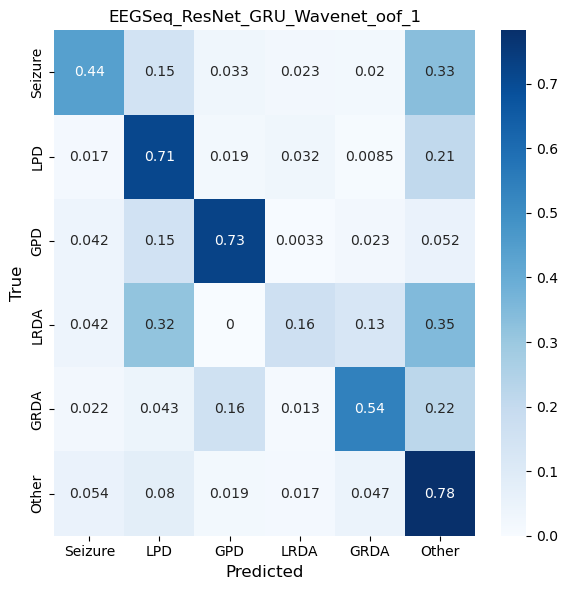

In [5]:
csv_path = f'./outputs/EEGSeq_ResNet_GRU_Wavenet_oof_1.csv'
print("CSV Path: ", csv_path)

oof_df = analyze_oof(csv_path)

print("Kaggle Score: ", calc_kaggle_score(oof_df))
print("Average KL Loss: ", oof_df["kl_loss"].mean())

display(oof_df.head())

# plot confusion matrix
cm = confusion_matrix(oof_df['target_id'], oof_df['target_pred']) # (y_true, y_pred)
cm = cm / cm.sum(axis=1)[:, np.newaxis]

fig = plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, cmap='Blues', xticklabels=TARGET2ID.keys(), yticklabels=TARGET2ID.keys())
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.title(csv_path.split('/')[-1].split('.')[0], fontsize=12)
fig.tight_layout()
fig.savefig(f"./outputs/{csv_path.split('/')[-1].split('.')[0]}_CM.png")
plt.show()